2) Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 5]

Загрузка данных student-por.csv

In [2]:
print("СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):")
try:
    df_student_single = pd.read_csv('../student-por.csv', sep=';')
    print("✓ Успешно загружено как одна колонка")
    print(f"  Исходный размер: {df_student_single.shape}")
    
    if df_student_single.shape[1] == 1:
        first_col = df_student_single.columns[0]
        print(f"  Единственная колонка: '{first_col}'")
        
        print("  Разделяем данные по запятой...")
        split_data = df_student_single[first_col].str.split(',', expand=True)
        print(f"  После разделения: {split_data.shape}")
        
        correct_columns = [
            'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 
            'G1', 'G2', 'G3'
        ]
        
        if split_data.shape[1] == len(correct_columns):
            split_data.columns = correct_columns
            df_student = split_data
            print("✓ Успешно присвоены названия колонок")
        else:
            print(f"⚠ Количество колонок не совпадает: ожидалось {len(correct_columns)}, получено {split_data.shape[1]}")
            split_data.columns = correct_columns[:split_data.shape[1]]
            df_student = split_data
            print("✓ Использованы доступные названия колонок")
        
        print("  Преобразуем числовые колонки...")
        numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                          'G1', 'G2', 'G3']
        
        for col in numeric_columns:
            if col in df_student.columns:
                df_student[col] = pd.to_numeric(df_student[col], errors='coerce')
                print(f"    ✓ '{col}' преобразована в числовой формат")
        
        print(f"✓ Итоговый размер: {df_student.shape}")
        print(f"✓ Колонки: {len(df_student.columns)}")
        print("\nПервые 3 строки после разделения:")
        print(df_student.head(3))
        
    else:
        df_student = df_student_single
        print("✓ Данные уже разделены")
        
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_student = None

СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):
✓ Успешно загружено как одна колонка
  Исходный размер: (649, 1)
  Единственная колонка: 'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3'
  Разделяем данные по запятой...
  После разделения: (649, 33)
✓ Успешно присвоены названия колонок
  Преобразуем числовые колонки...
    ✓ 'age' преобразована в числовой формат
    ✓ 'Medu' преобразована в числовой формат
    ✓ 'Fedu' преобразована в числовой формат
    ✓ 'traveltime' преобразована в числовой формат
    ✓ 'studytime' преобразована в числовой формат
    ✓ 'failures' преобразована в числовой формат
    ✓ 'famrel' преобразована в числовой формат
    ✓ 'freetime' преобразована в числовой формат
    ✓ 'goout' преобразована в числовой формат
    ✓ 'Dalc' преобразована в числовой формат
    ✓ 'Walc' преобразована в числовой

Загрузка данных house.csv

In [3]:
try:
    df_house = pd.read_csv('../house.csv')
    print("✓ Успешно загружено")
    print(f"  Размер: {df_house.shape}")
    print(f"  Колонки: {len(df_house.columns)}")
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_house = None

✓ Успешно загружено
  Размер: (4746, 12)
  Колонки: 12


Функции предобработки данных для классификации (студенческие данные)

In [4]:
def preprocess_student_classification(df):
    """Предобработка студенческих данных для классификации"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*50)
    
    if df is None:
        print("❌ DataFrame пустой")
        return None, None, None
    
    df_clean = df.copy()
    
    print("Доступные колонки:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1:2d}. '{col}' (тип: {df_clean[col].dtype})")
    
    if 'G3' not in df_clean.columns:
        print("❌ Колонка 'G3' не найдена!")
        print("   Доступные колонки:", list(df_clean.columns))
        return None, None, None
    
    print(f"✓ Найдена целевая переменная: 'G3'")
    print(f"  Диапазон значений: {df_clean['G3'].min()} - {df_clean['G3'].max()}")
    
    df_clean['academic_success'] = (df_clean['G3'] >= 10).astype(int)
    success_rate = df_clean['academic_success'].mean() * 100
    print(f"✓ Создана целевая переменная 'academic_success'")
    print(f"  Процент успевающих студентов: {success_rate:.1f}%")
    
    numeric_features = []
    possible_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    print("\nПоиск числовых признаков:")
    for feature in possible_numeric:
        if feature in df_clean.columns:
            if df_clean[feature].dtype == 'object':
                df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
            numeric_features.append(feature)
            print(f"  ✓ '{feature}' найден")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 
                           'Fjob', 'reason', 'guardian']
    
    features = numeric_features.copy()
    le = LabelEncoder()
    
    print("\nПоиск и кодирование категориальных признаков:")
    for feature in categorical_features:
        if feature in df_clean.columns:
            try:
                df_clean[f'{feature}_encoded'] = le.fit_transform(df_clean[feature].astype(str))
                features.append(f'{feature}_encoded')
                print(f"  ✓ '{feature}' закодирован")
            except Exception as e:
                print(f"  ✗ '{feature}' ошибка кодирования: {e}")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=features + ['academic_success'])
    final_count = len(df_clean)
    
    print(f"\n✓ Очистка данных: {initial_count} → {final_count} строк")
    print(f"✓ Используется {len(features)} признаков")
    
    if not features or df_clean.empty:
        print("❌ Недостаточно данных для анализа")
        return None, None, None
    
    X = df_clean[features]
    y = df_clean['academic_success']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Баланс классов: {np.bincount(y)}")
    
    return X, y, features

Функции предобработки данных для регрессии (данные о недвижимости)

In [5]:
def preprocess_house_regression(df):
    """Предобработка данных о недвижимости для регрессии"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)")
    print("="*50)
    
    if df is None:
        return None, None, None
    
    df_clean = df.copy()
    
    print(f"✓ Целевая переменная: Rent (арендная плата)")
    print(f"  Диапазон цен: {df_clean['Rent'].min()} - {df_clean['Rent'].max()}")
    
    if 'Floor' in df_clean.columns:
        def parse_floor(floor_str):
            if pd.isna(floor_str):
                return 0
            floor_str = str(floor_str)
            if 'Ground' in floor_str:
                return 0
            if 'Basement' in floor_str:
                return -1
            try:
                parts = floor_str.split()
                for part in parts:
                    if part.isdigit():
                        return int(part)
                return 0
            except:
                return 0
        
        df_clean['floor_number'] = df_clean['Floor'].apply(parse_floor)
        print("✓ Обработана колонка Floor")
    
    if 'Size' in df_clean.columns:
        try:
            df_clean['Size'] = df_clean['Size'].astype(str).str.replace(' sqft', '').astype(float)
            print("✓ Обработана колонка Size")
        except Exception as e:
            print(f"✗ Ошибка обработки Size: {e}")
    
    features = ['BHK', 'Bathroom']
    if 'Size' in df_clean.columns:
        features.append('Size')
    if 'floor_number' in df_clean.columns:
        features.append('floor_number')
    

    categorical_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
    le = LabelEncoder()
    
    for col in categorical_cols:
        if col in df_clean.columns:
            try:
                df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
                features.append(col + '_encoded')
                print(f"✓ Закодирована колонка: {col}")
            except Exception as e:
                print(f"✗ Ошибка кодирования {col}: {e}")
    
    X = df_clean[features]
    y = df_clean['Rent']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Статистика арендной платы: mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X, y, features

Функция исследования c логистической регрессией для классификации

In [6]:
def logistic_regression_study(X, y, dataset_name="Данные"):
    """Исследование логистической регрессии для классификации"""
    print(f"\n" + "="*70)
    print(f"ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния регуляризации на точность...")
    
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    train_scores = []
    test_scores = []
    
    for C in C_values:
        lr = LogisticRegression(
            C=C,
            max_iter=1000,
            random_state=42
        )
        lr.fit(X_train_scaled, y_train)
        train_scores.append(lr.score(X_train_scaled, y_train))
        test_scores.append(lr.score(X_test_scaled, y_test))
    
    best_C_index = np.argmax(test_scores)
    best_C = C_values[best_C_index]
    best_score = test_scores[best_C_index]
    best_train_score = train_scores[best_C_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальный C: {best_C}")
    print(f"  Лучшая точность: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(C_values, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(C_values, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучший C={best_C}')
    plt.xscale('log')
    plt.xlabel('Сила регуляризации (C)')
    plt.ylabel('Точность')
    plt.title(f'Логистическая регрессия - Влияние параметра C\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    best_lr.fit(X_train_scaled, y_train)
    y_pred = best_lr.predict(X_test_scaled)
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспех', 'Успех'], 
                yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Матрица ошибок (C={best_C})\nТочность: {best_score:.4f}', fontsize=12)
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
    print(f"  Оптимальный параметр C: {best_C}")
    print(f"  Точность на тестовой выборке: {best_score:.4f}")
    print(f"  Точность на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test accuracy: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print(f"  Precision (Точность): {precision:.4f}")
    print(f"  Recall (Полнота): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    if best_score >= 0.9:
        print("  🎉 Отличное качество модели (Точность ≥ 0.9)")
    elif best_score >= 0.8:
        print("  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)")
    elif best_score >= 0.7:
        print("  👌 Удовлетворительное качество модели (0.7 ≤ Точность < 0.8)")
    else:
        print("  💡 Низкое качество модели (Точность < 0.7)")
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
    print(classification_report(y_test, y_pred, target_names=['Неуспех', 'Успех']))
    
    return best_lr, best_C, best_score

Функция исследования с линейной регрессией для регрессии

In [7]:
def linear_regression_study(X, y, dataset_name="Данные"):
    """Исследование линейной регрессии"""
    from sklearn.linear_model import Ridge 
    
    print(f"\n" + "="*70)
    print(f"ЛИНЕЙНАЯ РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния регуляризации на R² score...")
    
    alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    train_scores = []
    test_scores = []
    
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha, random_state=42)
        ridge.fit(X_train_scaled, y_train)
        train_scores.append(ridge.score(X_train_scaled, y_train))
        test_scores.append(ridge.score(X_test_scaled, y_test))
    
    best_alpha_index = np.argmax(test_scores)
    best_alpha = alpha_values[best_alpha_index]
    best_score = test_scores[best_alpha_index]
    best_train_score = train_scores[best_alpha_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальный alpha: {best_alpha}")
    print(f"  Лучший R² score: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(alpha_values, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(alpha_values, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, label=f'Лучший alpha={best_alpha}')
    plt.xscale('log')
    plt.xlabel('Сила регуляризации (alpha)')
    plt.ylabel('R² Score')
    plt.title(f'Ridge Регрессия - Влияние регуляризации\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_model = Ridge(alpha=best_alpha, random_state=42)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {best_score:.4f}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ:")
    print(f"  Оптимальный параметр регуляризации (alpha): {best_alpha}")
    print(f"  R² score на тестовой выборке: {best_score:.4f}")
    print(f"  R² score на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test R²: {abs(overfitting_gap):.4f}")
    
    if abs(overfitting_gap) > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:")
    print(f"  MSE (Mean Squared Error): {mse:.2f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.2f}")
    
    if best_score >= 0.7:
        print("  🎉 Отличное качество модели (R² ≥ 0.7)")
    elif best_score >= 0.5:
        print("  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)")
    elif best_score >= 0.3:
        print("  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 Низкое качество модели (R² < 0.3)")
    
    if hasattr(best_model, 'coef_'):
        coef = best_model.coef_
        
        print(f"\n📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:")
        print(f"  Количество признаков: {len(coef)}")
        
        if len(coef) <= 10: 
            for i, c in enumerate(coef):
                sign = "+" if c > 0 else ""
                print(f"  Коэффициент признака {i+1}: {sign}{c:.4f}")
        else: 
            print(f"\n🔝 ТОП-5 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
            abs_coef = abs(coef)
            top_indices = np.argsort(abs_coef)[-5:][::-1]
            
            for idx in top_indices:
                sign = "+" if coef[idx] > 0 else ""
                print(f"  Признак {idx+1}: {sign}{coef[idx]:.4f}")
    
    if hasattr(best_model, 'intercept_'):
        print(f"  Интерцепт (свободный член): {best_model.intercept_:.4f}")
    
    return best_model, best_alpha, best_score

3) Сформулируем гипотезы: препроцессинг данных (более тщательная обработка выбросов улучшит качество моделей)

In [8]:
def advanced_preprocessing(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR"""
    numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                      'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                      'G1', 'G2', 'G3']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

def advanced_preprocessing_house(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR для house данных"""
    numeric_columns = ['BHK', 'Bathroom', 'Size', 'Rent']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

инженеря признаков (создание новых признаков повысит предсказательную силу)

In [9]:
def feature_engineering(df):
    """Создание новых признаков для улучшения моделей"""
    print("🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...")
    
    df_fe = df.copy()
    
    if 'G1' in df.columns and 'G2' in df.columns:
        df_fe['grade_trend'] = df_fe['G2'] - df_fe['G1']
        print("  ✓ Создан признак 'grade_trend' (тренд успеваемости)")
    
    if 'Dalc' in df.columns and 'Walc' in df.columns:
        df_fe['total_alcohol'] = df_fe['Dalc'] + df_fe['Walc']
        print("  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)")
    
    if 'studytime' in df.columns and 'goout' in df.columns:
        df_fe['study_effort'] = df_fe['studytime'] * (1 - df_fe['goout']/5)
        print("  ✓ Создан признак 'study_effort' (индекс учебных усилий)")
    
    if 'Size' in df.columns and 'BHK' in df.columns and 'Rent' in df.columns:
        df_fe['price_per_sqft'] = df_fe['Rent'] / df_fe['Size']
        print("  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)")
        
        df_fe['room_density'] = df_fe['BHK'] / df_fe['Size']
        print("  ✓ Создан признак 'room_density' (плотность комнат)")
    
    return df_fe

визуализация и EDA (глубокий анализ данных выявит скрытые зависимости)

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

def evaluate_with_eda_insights_logistic_regression(X, y, dataset_name="Данные"):
    """Оценка модели с использованием инсайтов из EDA для логистической регрессии"""
    print(f"\n🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EДА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ({dataset_name})")
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    feature_imp = pd.Series(model.feature_importances_, index=X.columns)
    top_features = feature_imp.nlargest(int(len(feature_imp) * 0.8))
    X_reduced = X[top_features.index]
    
    print(f"  ✓ Отобрано {len(top_features)} самых важных признаков из {len(feature_imp)}")
    print(f"  ✓ Топ-3 признака: {list(top_features.head(3).index)}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    
    score = log_reg.score(X_test_scaled, y_test)
    print(f"  ✓ Точность логистической регрессии с отобранными признаками: {score:.4f}")
    print(f"  ✓ Количество итераций обучения: {log_reg.n_iter_[0]}")
    print(f"  ✓ Количество коэффициентов: {len(log_reg.coef_[0])}")
    
    return score, top_features.index

def evaluate_with_eda_insights_linear_regression(X, y, dataset_name="Данные"):
    """Оценка модели с использованием инсайтов из EDA для линейной регрессии"""
    print(f"\n🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EДА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ ({dataset_name})")
    
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    feature_imp = pd.Series(model.feature_importances_, index=X.columns)
    top_features = feature_imp.nlargest(int(len(feature_imp) * 0.8))
    X_reduced = X[top_features.index]
    
    print(f"  ✓ Отобрано {len(top_features)} самых важных признаков из {len(feature_imp)}")
    print(f"  ✓ Топ-3 признака: {list(top_features.head(3).index)}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    
    score = lin_reg.score(X_test_scaled, y_test)
    print(f"  ✓ R² линейной регрессии с отобранными признаками: {score:.4f}")
    
    print(f"  ✓ Коэффициент детерминации (R²): {score:.4f}")
    print(f"  ✓ Количество коэффициентов: {len(lin_reg.coef_)}")
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    y_pred = lin_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"  ✓ Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"  ✓ Средняя абсолютная ошибка (MAE): {mae:.4f}")
    
    return score, top_features.index, lin_reg

подбор гиперпараметров (подбор гиперпараметров с использованием кросс-валидации)

In [11]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def hyperparameter_tuning_linear_models(X, y, problem_type='classification', dataset_name="Данные"):
    """Подбор гиперпараметров для линейных моделей с использованием кросс-валидации"""
    print(f"\n🎯 ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ ЛИНЕЙНЫХ МОДЕЛЕЙ ({dataset_name})")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42,
        stratify=y if problem_type == 'classification' else None
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if problem_type == 'classification':
        base_model = LogisticRegression(max_iter=10000, random_state=42)
        scoring = 'accuracy'
        
        param_grid = {
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'C': np.logspace(-4, 4, 20),
            'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] 
        }
        
        param_grid_list = [
            {
                'penalty': ['l1'],
                'C': np.logspace(-4, 4, 20),
                'solver': ['liblinear', 'saga']
            },
            {
                'penalty': ['l2'],
                'C': np.logspace(-4, 4, 20),
                'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
            },
            {
                'penalty': ['elasticnet'],
                'C': np.logspace(-4, 4, 20),
                'solver': ['saga'],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            },
            {
                'penalty': [None],
                'C': [1.0],
                'solver': ['lbfgs', 'newton-cg']
            }
        ]
        
    else:
        model_choice = 'ridge' 
        
        if model_choice == 'ridge':
            base_model = Ridge(random_state=42)
            param_name = 'alpha'
        elif model_choice == 'lasso':
            base_model = Lasso(random_state=42, max_iter=10000)
            param_name = 'alpha'
        elif model_choice == 'elasticnet':
            base_model = ElasticNet(random_state=42, max_iter=10000)
            param_name = 'alpha'
        else:
            from sklearn.linear_model import LinearRegression
            base_model = LinearRegression()
            param_name = 'fit_intercept'
        
        scoring = 'r2'
        
        param_grid = {
            'alpha': np.logspace(-4, 4, 20),
            'fit_intercept': [True, False],
            'max_iter': [1000, 5000, 10000]
        }
        
        param_grid_list = [
            {
                'alpha': np.logspace(-4, 4, 20),
                'fit_intercept': [True, False],
                'max_iter': [10000]
            }
        ]
    
    if problem_type == 'classification':
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_simple = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_simple = KFold(n_splits=5, shuffle=True, random_state=42)
    
    print("🔍 Запуск GridSearchCV для линейных моделей...")
    
    best_score = -np.inf
    best_params = None
    best_model = None
    all_results = []
    
    for params in param_grid_list:
        grid_search = GridSearchCV(
            base_model, params, cv=cv, scoring=scoring,
            n_jobs=-1, verbose=0, return_train_score=True
        )
        
        try:
            grid_search.fit(X_train_scaled, y_train)
            
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_params = grid_search.best_params_
                best_model = grid_search.best_estimator_
            
            for i in range(len(grid_search.cv_results_['params'])):
                all_results.append({
                    'params': grid_search.cv_results_['params'][i],
                    'mean_test_score': grid_search.cv_results_['mean_test_score'][i],
                    'std_test_score': grid_search.cv_results_['std_test_score'][i],
                    'mean_train_score': grid_search.cv_results_['mean_train_score'][i]
                })
                
        except Exception as e:
            print(f"  ⚠️ Пропускаем комбинацию параметров: {e}")
            continue
    
    test_score = best_model.score(X_test_scaled, y_test)
    
    print(f"  ✓ Лучшие параметры: {best_params}")
    print(f"  ✓ Лучшая оценка на кросс-валидации: {best_score:.4f}")
    print(f"  ✓ Оценка на тестовой выборке: {test_score:.4f}")
    
    plt.figure(figsize=(18, 6))
    
    if problem_type == 'classification':
        plt.subplot(1, 3, 1)
        
        c_values = []
        c_scores = []
        c_stds = []
        
        for result in all_results:
            if 'C' in result['params']:
                c_values.append(result['params']['C'])
                c_scores.append(result['mean_test_score'])
                c_stds.append(result['std_test_score'])
        
        if c_values:
            sorted_indices = np.argsort(c_values)
            c_values = np.array(c_values)[sorted_indices]
            c_scores = np.array(c_scores)[sorted_indices]
            c_stds = np.array(c_stds)[sorted_indices]
            
            plt.semilogx(c_values, c_scores, 'o-', linewidth=2, markersize=6, label='CV Score')
            plt.fill_between(c_values, 
                           c_scores - c_stds,
                           c_scores + c_stds,
                           alpha=0.2)
            
            if 'C' in best_params:
                plt.axvline(x=best_params['C'], color='red', linestyle='--', 
                          label=f'Лучшее C: {best_params["C"]:.4f}')
            
            plt.xlabel('Параметр регуляризации C (log scale)')
            plt.ylabel('Accuracy')
            plt.title('Влияние параметра C на точность')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        
        penalty_scores = {}
        penalty_counts = {}
        
        for result in all_results:
            penalty = result['params'].get('penalty', 'none')
            if penalty not in penalty_scores:
                penalty_scores[penalty] = 0
                penalty_counts[penalty] = 0
            
            penalty_scores[penalty] += result['mean_test_score']
            penalty_counts[penalty] += 1
        
        penalties = list(penalty_scores.keys())
        avg_scores = [penalty_scores[p] / penalty_counts[p] for p in penalties]
        
        bars = plt.bar(penalties, avg_scores, alpha=0.7, 
                      color=['skyblue', 'lightgreen', 'salmon', 'gold'])
        
        plt.ylabel('Средняя Accuracy')
        plt.title('Сравнение типов регуляризации')
        plt.xticks(rotation=45)
        
        for bar, score in zip(bars, avg_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.4f}', ha='center', va='bottom', fontsize=9)
        
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        
        solver_scores = {}
        solver_counts = {}
        
        for result in all_results:
            solver = result['params'].get('solver', 'unknown')
            if solver not in solver_scores:
                solver_scores[solver] = 0
                solver_counts[solver] = 0
            
            solver_scores[solver] += result['mean_test_score']
            solver_counts[solver] += 1
        
        solvers = list(solver_scores.keys())
        avg_scores = [solver_scores[s] / solver_counts[s] for s in solvers]
        
        bars = plt.bar(solvers, avg_scores, alpha=0.7, 
                      color=['lightcoral', 'lightblue', 'lightgreen', 'yellow', 'orange'])
        
        plt.ylabel('Средняя Accuracy')
        plt.title('Сравнение алгоритмов оптимизации')
        plt.xticks(rotation=45)
        
        for bar, score in zip(bars, avg_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.4f}', ha='center', va='bottom', fontsize=9)
        
        plt.grid(True, alpha=0.3)
    
    else:  
        plt.subplot(1, 3, 1)
        
        alpha_values = []
        alpha_scores = []
        alpha_stds = []
        
        for result in all_results:
            if 'alpha' in result['params']:
                alpha_values.append(result['params']['alpha'])
                alpha_scores.append(result['mean_test_score'])
                alpha_stds.append(result['std_test_score'])
        
        if alpha_values:
            sorted_indices = np.argsort(alpha_values)
            alpha_values = np.array(alpha_values)[sorted_indices]
            alpha_scores = np.array(alpha_scores)[sorted_indices]
            alpha_stds = np.array(alpha_stds)[sorted_indices]
            
            plt.semilogx(alpha_values, alpha_scores, 'o-', linewidth=2, markersize=6, label='CV Score')
            plt.fill_between(alpha_values,
                           alpha_scores - alpha_stds,
                           alpha_scores + alpha_stds,
                           alpha=0.2)
            
            if 'alpha' in best_params:
                plt.axvline(x=best_params['alpha'], color='red', linestyle='--',
                          label=f'Лучшее alpha: {best_params["alpha"]:.4f}')
            
            plt.xlabel('Параметр регуляризации alpha (log scale)')
            plt.ylabel('R² Score')
            plt.title('Влияние alpha на качество модели')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        
        intercept_scores = {True: [], False: []}
        
        for result in all_results:
            fit_intercept = result['params'].get('fit_intercept', True)
            if fit_intercept in intercept_scores:
                intercept_scores[fit_intercept].append(result['mean_test_score'])
        
        labels = ['С intercept', 'Без intercept']
        means = [np.mean(intercept_scores[True]) if intercept_scores[True] else 0,
                np.mean(intercept_scores[False]) if intercept_scores[False] else 0]
        stds = [np.std(intercept_scores[True]) if intercept_scores[True] else 0,
               np.std(intercept_scores[False]) if intercept_scores[False] else 0]
        
        bars = plt.bar(labels, means, yerr=stds, alpha=0.7, 
                      color=['lightblue', 'lightcoral'], capsize=10)
        
        plt.ylabel('Средний R²')
        plt.title('Влияние fit_intercept на качество')
        
        for bar, mean in zip(bars, means):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{mean:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        
        train_scores = []
        test_scores = []
        
        for result in all_results:
            train_scores.append(result['mean_train_score'])
            test_scores.append(result['mean_test_score'])
        
        plt.scatter(train_scores, test_scores, alpha=0.6, c='blue', s=50)
        plt.plot([min(train_scores), max(train_scores)], 
                [min(train_scores), max(train_scores)], 
                'r--', linewidth=1, label='Идеальная линия')
        
        plt.xlabel('Train Score')
        plt.ylabel('CV Test Score')
        plt.title('Сравнение train и test scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    train_test_gap = 0
    if all_results:
        best_result = next((r for r in all_results if r['params'] == best_params), None)
        if best_result:
            train_test_gap = best_result['mean_train_score'] - best_result['mean_test_score']
    
    print(f"\n📊 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
    print(f"  Разница между train и CV score: {train_test_gap:.4f}")
    
    if train_test_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница)")
    elif train_test_gap > 0.05:
        print("  ⚠️ Умеренное переобучение")
    else:
        print("  ✅ Хорошее обобщение (малая разница)")
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ЛИНЕЙНЫХ МОДЕЛЕЙ:")
    
    if problem_type == 'classification':
        if hasattr(best_model, 'coef_'):
            coef_magnitude = np.mean(np.abs(best_model.coef_))
            print(f"  ✓ Средняя величина коэффициентов: {coef_magnitude:.4f}")
            
            if hasattr(best_model, 'coef_') and len(best_model.coef_.shape) > 1:
                feature_importance = np.mean(np.abs(best_model.coef_), axis=0)
                top_features_idx = np.argsort(feature_importance)[-3:][::-1]
                
                if hasattr(X, 'columns'):
                    top_features = X.columns[top_features_idx]
                    print(f"  ✓ Топ-3 важных признаков: {list(top_features)}")
    
    else:
        if hasattr(best_model, 'coef_'):
            nonzero_coef = np.sum(best_model.coef_ != 0)
            total_coef = len(best_model.coef_)
            print(f"  ✓ Ненулевых коэффициентов: {nonzero_coef}/{total_coef} ({(nonzero_coef/total_coef*100):.1f}%)")
            
            coef_magnitude = np.mean(np.abs(best_model.coef_))
            print(f"  ✓ Средняя величина коэффициентов: {coef_magnitude:.4f}")
    
    return best_model, best_params, test_score

оптимизация порога классификации (настройка порога классификации улучшит precision/recall)

In [12]:
def optimize_threshold(model, X_test, y_test, model_name="Модель"):
    """Оптимизация порога классификации для улучшения метрик"""
    from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, f1_score
    
    print(f"\n🎯 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ {model_name}")
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_f1 = f1_scores[best_f1_index]
    
    balance_index = np.argmin(np.abs(precision[:-1] - recall[:-1]))
    balance_threshold = thresholds[balance_index]
    balance_f1 = f1_scores[balance_index]
    
    print(f"  ✓ Оптимальный порог по F1-score: {best_threshold:.4f} (F1 = {best_f1:.4f})")
    print(f"  ✓ Сбалансированный порог: {balance_threshold:.4f} (F1 = {balance_f1:.4f})")
    
    y_pred_default = (y_proba >= 0.5).astype(int)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    default_f1 = f1_score(y_test, y_pred_default)
    
    y_pred_optimized = (y_proba >= best_threshold).astype(int)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized)
    
    print(f"\n📊 СРАВНЕНИЕ С ПОРОГОМ ПО УМОЛЧАНИЮ (0.5):")
    print(f"  По умолчанию (0.5):    Accuracy = {default_accuracy:.4f}, F1 = {default_f1:.4f}")
    print(f"  Оптимизированный:      Accuracy = {optimized_accuracy:.4f}, F1 = {optimized_f1:.4f}")
    
    improvement_f1 = optimized_f1 - default_f1
    if improvement_f1 > 0:
        print(f"  🎉 УЛУЧШЕНИЕ F1: +{improvement_f1:.4f}")
    else:
        print(f"  📉 УХУДШЕНИЕ F1: {improvement_f1:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)
    plt.axvline(x=best_threshold, color='red', linestyle='--', 
                label=f'Лучший порог: {best_threshold:.3f}', alpha=0.7)
    plt.axvline(x=0.5, color='black', linestyle='--', 
                label='Порог по умолчанию: 0.5', alpha=0.7)
    plt.axvline(x=balance_threshold, color='orange', linestyle='--', 
                label=f'Сбалансированный: {balance_threshold:.3f}', alpha=0.7)
    plt.xlabel('Порог классификации')
    plt.ylabel('Score')
    plt.title('Precision, Recall и F1 vs Порог')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Кривая Precision-Recall')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    metrics = ['Accuracy', 'F1-Score']
    default_scores = [default_accuracy, default_f1]
    optimized_scores = [optimized_accuracy, optimized_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, default_scores, width, label='Порог 0.5', alpha=0.7)
    plt.bar(x + width/2, optimized_scores, width, label='Оптимизированный', alpha=0.7)
    
    plt.xlabel('Метрики')
    plt.ylabel('Score')
    plt.title('Сравнение метрик\nдо и после оптимизации порога')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, (default, optimized) in enumerate(zip(default_scores, optimized_scores)):
        plt.text(i - width/2, default + 0.01, f'{default:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, optimized + 0.01, f'{optimized:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:")
    print("  С порогом по умолчанию (0.5):")
    print(classification_report(y_test, y_pred_default, target_names=['Неуспех', 'Успех']))
    
    print("  С оптимизированным порогом:")
    print(classification_report(y_test, y_pred_optimized, target_names=['Неуспех', 'Успех']))
    
    return best_threshold, optimized_f1, optimized_accuracy

Проверяем гипотезы:

1) (классификация)


🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'a

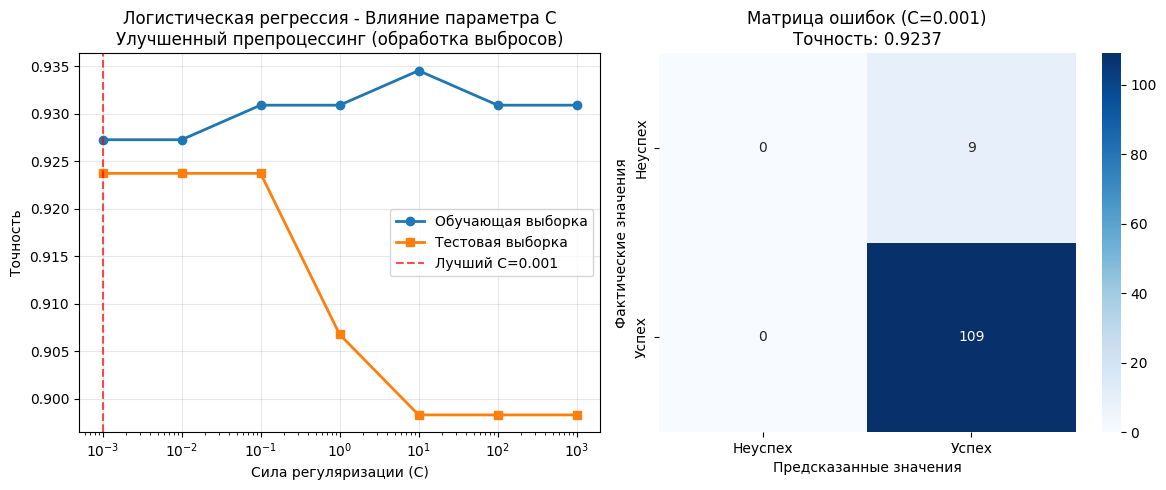


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.9237
  Точность на обучающей выборке: 0.9273
  Разница между train и test accuracy: 0.0035
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.9237
  Recall (Полнота): 1.0000
  F1-Score: 0.9604
  🎉 Отличное качество модели (Точность ≥ 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      1.00      0.96       109

    accuracy                           0.92       118
   macro avg       0.46      0.50      0.48       118
weighted avg       0.85      0.92      0.89       118


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
------------------------------------------------------------
  Обработка выбросов:             0.9237

  🏆 Лучший метод: 'Обработка выбросов' с точностью 0.9237

🔍 АНАЛИЗ ИЗМЕ

In [13]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ")
    print("="*80)
    
    df_advanced = advanced_preprocessing(df_student)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...")
    X_advanced, y_advanced, features_advanced = preprocess_student_classification(df_advanced)
    
    if X_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ")
        lr_advanced, _, score_advanced = logistic_regression_study(
            X_advanced, y_advanced, "Улучшенный препроцессинг (обработка выбросов)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}

        if 'score_class' in locals():
            comparison_data['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        comparison_data['Обработка выбросов'] = score_advanced
        print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        if comparison_data: 
            best_method = max(comparison_data.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method[0]}' с точностью {best_method[1]:.4f}")
        
        if 'score_class' in locals():
            improvement = score_advanced - score_class
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_class*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_class*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        if len(comparison_data) > 1:
            plt.figure(figsize=(10, 6))
            methods = list(comparison_data.keys())
            scores = list(comparison_data.values())
            
            if len(methods) == 2:
                colors = ['lightblue', 'lightgreen']
            elif len(methods) == 3:
                colors = ['lightblue', 'lightgreen', 'salmon']
            else:
                colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
            
            bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
            plt.ylabel('Точность (Accuracy)', fontsize=12)
            plt.title('Сравнение методов препроцессинга\nСтуденческие данные (классификация)', fontsize=14, fontweight='bold')
            plt.ylim(0, 1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            if 'score_class' in locals() and len(methods) > 1:
                plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                           label=f'Базовое значение: {score_class:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        if df_advanced is not None and 'df_student' in locals():
            try:
                print("\n🔍 АНАЛИЗ ИЗМЕНЕНИЙ ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ:")
                
                print(f"  Исходный размер данных: {df_student.shape}")
                print(f"  Размер после обработки: {df_advanced.shape}")
                
                numeric_cols = df_student.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    print(f"\n  📊 Статистика по выбросам:")
                    for col in numeric_cols[:5]: 
                        if col in df_student.columns and col in df_advanced.columns:
                            Q1 = df_student[col].quantile(0.25)
                            Q3 = df_student[col].quantile(0.75)
                            IQR = Q3 - Q1
                            outliers_original = df_student[(df_student[col] < (Q1 - 1.5 * IQR)) | 
                                                          (df_student[col] > (Q3 + 1.5 * IQR))].shape[0]
                            outliers_advanced = df_advanced[(df_advanced[col] < (Q1 - 1.5 * IQR)) | 
                                                           (df_advanced[col] > (Q3 + 1.5 * IQR))].shape[0]
                            reduction = ((outliers_original - outliers_advanced) / outliers_original * 100) if outliers_original > 0 else 0
                            print(f"    {col}: {outliers_original} → {outliers_advanced} выбросов ({reduction:.1f}% снижение)")
                
                if 'G3' in df_student.columns and 'G3' in df_advanced.columns:
                    print(f"\n  🎯 Распределение оценок (G3):")
                    print(f"    Среднее: {df_student['G3'].mean():.2f} → {df_advanced['G3'].mean():.2f}")
                    print(f"    Стандартное отклонение: {df_student['G3'].std():.2f} → {df_advanced['G3'].std():.2f}")
                    
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать изменения: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с улучшенным препроцессингом")
else:
    print("❌ Студенческие данные не загружены")

1) (Регрессия)


🎯 ГИПОТЕЗА 2: ОБРАБОТКА ВЫБРОСОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

📊 ПОДГОТОВКА ДАННЫХ С ОБРАБОТКОЙ ВЫБРОСОВ...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 67000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4131 samples, 9 features
  Статистика арендной платы: mean=18797.22, std=13407.16

🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С ОБРАБОТКОЙ ВЫБРОСОВ

ЛИНЕЙНАЯ РЕГРЕССИЯ - Обработка выбросов (house данные)
🔍 Исследование влияния регуляриз

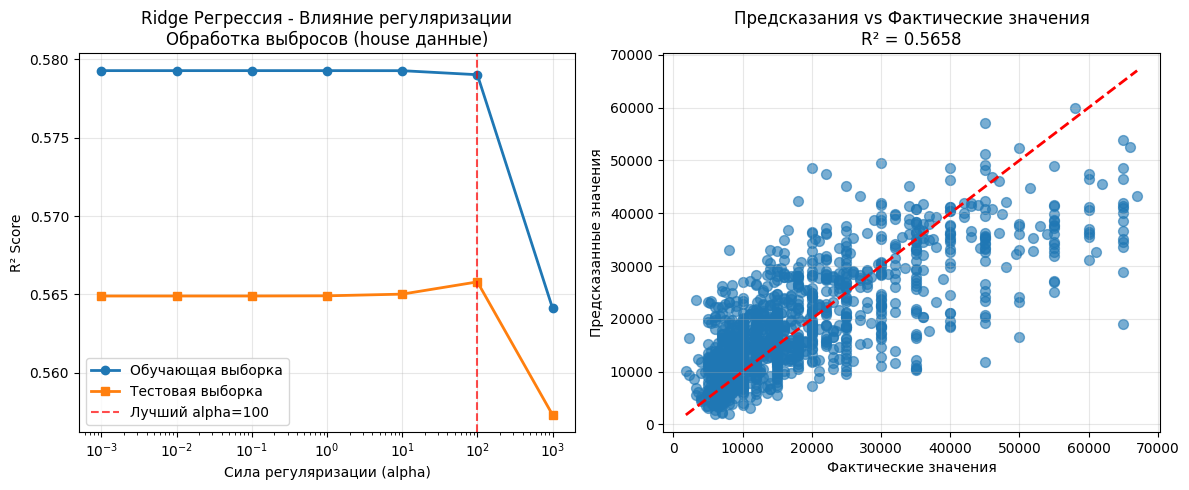


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 100
  R² score на тестовой выборке: 0.5658
  R² score на обучающей выборке: 0.5790
  Разница между train и test R²: 0.0132
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 78086573.16
  RMSE (Root Mean Squared Error): 8836.66
  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1487.1860
  Коэффициент признака 2: +2878.0651
  Коэффициент признака 3: +1322.8449
  Коэффициент признака 4: +2913.3359
  Коэффициент признака 5: -399.1746
  Коэффициент признака 6: +2233.4512
  Коэффициент признака 7: -1528.3352
  Коэффициент признака 8: -167.9614
  Коэффициент признака 9: -4961.9135
  Интерцепт (свободный член): 18755.5870

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ
------------------------------------------------------------
  Обработка выбросов:             0.5658

  🏆 Лучший метод: '

In [14]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: ОБРАБОТКА ВЫБРОСОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)

    df_house_advanced = advanced_preprocessing_house(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С ОБРАБОТКОЙ ВЫБРОСОВ...")
    X_house_advanced, y_house_advanced, features_house_advanced = preprocess_house_regression(df_house_advanced)
    
    if X_house_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С ОБРАБОТКОЙ ВЫБРОСОВ")
        knn_house_advanced, k_house_advanced, score_house_advanced = linear_regression_study(
            X_house_advanced, y_house_advanced, "Обработка выбросов (house данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}
        
        if 'score_house' in locals():
            comparison_data['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        comparison_data['Обработка выбросов'] = score_house_advanced
        print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        if comparison_data:
            best_method = max(comparison_data.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method[0]}' с R² = {best_method[1]:.4f}")
        
        if 'score_house' in locals():
            improvement = score_house_advanced - score_house
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_house*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_house*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        if len(comparison_data) > 1:
            plt.figure(figsize=(10, 6))
            methods = list(comparison_data.keys())
            scores = list(comparison_data.values())
            
            if len(methods) == 2:
                colors = ['lightblue', 'lightgreen']
            else:
                colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
            
            bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
            plt.ylabel('R² Score', fontsize=12)
            plt.title('Сравнение методов препроцессинга\nHouse данные (регрессия)', fontsize=14, fontweight='bold')
            plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            if 'score_house' in locals() and len(methods) > 1:
                plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                           label=f'Базовое значение: {score_house:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        if 'features_house' in locals() and features_house_advanced is not None:
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_house)}")
            print(f"    После обработки выбросов: {len(features_house_advanced)}")
            
            original_features_set = set(features_house) if 'features_house' in locals() else set()
            new_features_set = set(features_house_advanced)
            
            if original_features_set == new_features_set:
                print(f"    ✅ Признаки остались те же (только очищенные от выбросов)")
            else:
                removed_features = list(original_features_set - new_features_set)
                if removed_features:
                    print(f"    ❌ Удаленные признаки: {len(removed_features)}")
                    for feature in removed_features[:3]: 
                        print(f"      - {feature}")
    
    else:
        print("❌ Не удалось подготовить данные с обработкой выбросов")
else:
    print("❌ House данные не загружены")

2) (Классификация)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'grade_trend' (тренд успеваемости)
  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)
  ✓ Создан признак 'study_effort' (индекс учебных усилий)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: obje

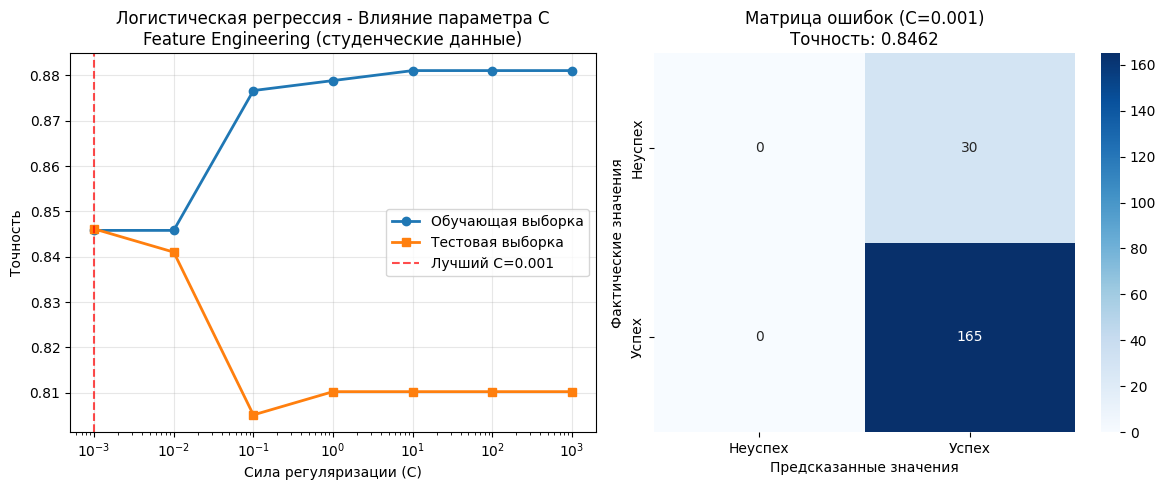


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.8462
  Точность на обучающей выборке: 0.8458
  Разница между train и test accuracy: -0.0003
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8462
  Recall (Полнота): 1.0000
  F1-Score: 0.9167
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00        30
       Успех       0.85      1.00      0.92       165

    accuracy                           0.85       195
   macro avg       0.42      0.50      0.46       195
weighted avg       0.72      0.85      0.78       195


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
------------------------------------------------------------
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8462

  🏆 Лучший метод: 'Обрабо

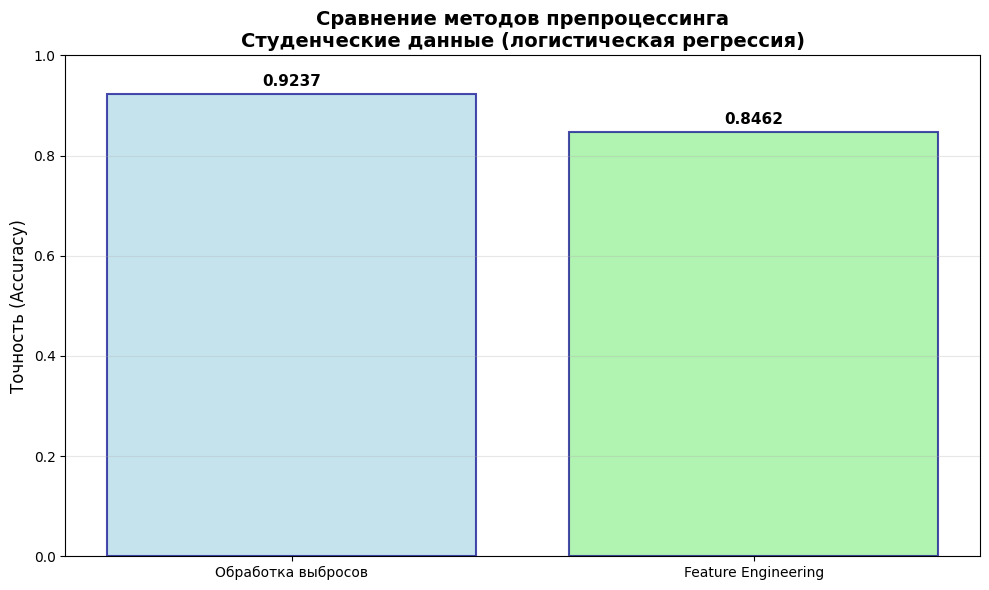


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  grade_trend: корреляция с целевой переменной = 0.1216
  total_alcohol: корреляция с целевой переменной = -0.1323
  study_effort: корреляция с целевой переменной = 0.1325

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Топ-10 самых важных признаков:
    failures: -0.0612 (🔽 Отрицат.)
    school_encoded: -0.0450 (🔽 Отрицат.)
    Medu: 0.0281 (🔼 Положит.)
    studytime: 0.0261 (🔼 Положит.)
    goout: -0.0236 (🔽 Отрицат.)
    Walc: -0.0227 (🔽 Отрицат.)
    freetime: -0.0227 (🔽 Отрицат.)
    Dalc: -0.0222 (🔽 Отрицат.)
    reason_encoded: 0.0208 (🔼 Положит.)
    Fedu: 0.0207 (🔼 Положит.)


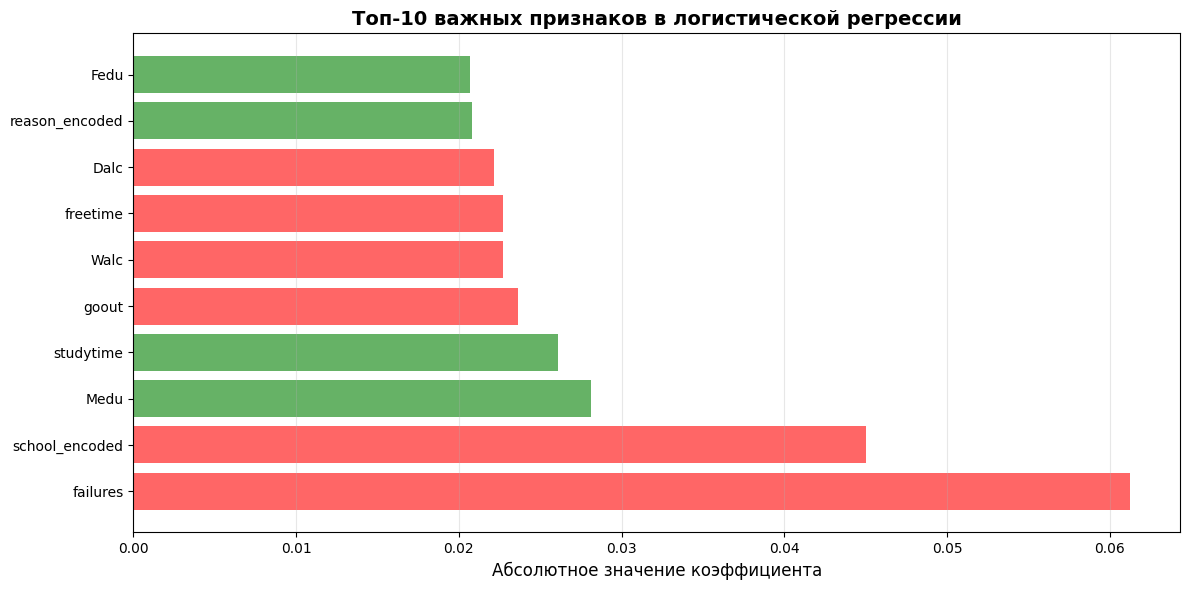


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:

📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:
  Общее количество признаков: 22
  Количество новых признаков: 3
  Размер обучающей выборки: (649, 22)


In [15]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    df_student_fe = feature_engineering(df_student)
    
    df_student_fe['academic_success'] = (df_student_fe['G3'] >= 10).astype(int)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_student_fe, y_student_fe, features_student_fe = preprocess_student_classification(df_student_fe)
    
    if X_student_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        lr_student_fe, _, score_student_fe = logistic_regression_study(
            X_student_fe, y_student_fe, "Feature Engineering (студенческие данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}
        
        if 'score_class' in locals():
            comparison_data['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data['Обработка выбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        comparison_data['Feature Engineering'] = score_student_fe
        print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        best_method = max(comparison_data.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method[0]}' с точностью {best_method[1]:.4f}")
        
        if 'score_class' in locals():
            improvement = score_student_fe - score_class
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_class*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_class*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data.keys())
        scores = list(comparison_data.values())
        
        if len(methods) == 2:
            colors = ['lightblue', 'lightgreen']
        elif len(methods) == 3:
            colors = ['lightblue', 'lightgreen', 'salmon']
        else:
            colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
        plt.ylabel('Точность (Accuracy)', fontsize=12)
        plt.title('Сравнение методов препроцессинга\nСтуденческие данные (логистическая регрессия)', fontsize=14, fontweight='bold')
        plt.ylim(0, 1)
        
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        if 'score_class' in locals() and len(methods) > 1:
            plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                       label=f'Базовое значение: {score_class:.4f}')
            plt.legend(loc='best')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features = ['grade_trend', 'total_alcohol', 'study_effort']
        available_new_features = [f for f in new_features if f in df_student_fe.columns]
        
        correlations = {}
        for feature in available_new_features:
            correlation = df_student_fe[feature].corr(df_student_fe['academic_success'])
            correlations[feature] = correlation
            print(f"  {feature}: корреляция с целевой переменной = {correlation:.4f}")
        
        if lr_student_fe is not None and features_student_fe is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
                
                coefficients = lr_student_fe.coef_[0]
                feature_importance = pd.DataFrame({
                    'Признак': features_student_fe,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "🔼 Положит." if row['Коэффициент'] > 0 else "🔽 Отрицат."
                    print(f"    {row['Признак']}: {row['Коэффициент']:.4f} ({sign})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в логистической регрессии', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
                
                print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:")
                for feature in available_new_features:
                    if feature in feature_importance['Признак'].values:
                        importance_row = feature_importance[feature_importance['Признак'] == feature]
                        if not importance_row.empty:
                            coef = importance_row.iloc[0]['Коэффициент']
                            abs_coef = importance_row.iloc[0]['Абс.значение']
                            rank = feature_importance[feature_importance['Абс.значение'] >= abs_coef].shape[0]
                            direction = "увеличивает вероятность успеха" if coef > 0 else "уменьшает вероятность успеха"
                            print(f"  {feature}:")
                            print(f"    Коэффициент: {coef:.4f} ({direction})")
                            print(f"    Ранг важности: {rank}/{len(feature_importance)}")
                            
                            if feature in correlations:
                                corr = correlations[feature]
                                agreement = "согласуется" if (coef > 0 and corr > 0) or (coef < 0 and corr < 0) else "противоречит"
                                print(f"    Корреляция: {corr:.4f} ({agreement} с моделью)")
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
        
        print("\n📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:")
        print(f"  Общее количество признаков: {len(features_student_fe)}")
        print(f"  Количество новых признаков: {len(available_new_features)}")
        print(f"  Размер обучающей выборки: {X_student_fe.shape}")
        
        if 'X_class' in locals() and 'features_class' in locals():
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_class)}")
            print(f"    После feature engineering: {len(features_student_fe)}")
            
            original_set = set(features_class)
            new_set = set(features_student_fe)
            added_features = list(new_set - original_set)
            
            if added_features:
                print(f"    Добавлено признаков: {len(added_features)}")
                print(f"    Новые признаки: {', '.join(added_features[:5])}" + 
                      (f", ..." if len(added_features) > 5 else ""))
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")
else:
    print("❌ Студенческие данные не загружены")

2) (Регрессия)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)
  ✓ Создан признак 'room_density' (плотность комнат)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING

ЛИНЕЙНАЯ РЕГРЕССИЯ - Feature Engineering (house данные)
🔍 Исследование влияния регуляризации на R² score...


🎯 Результаты:
  Оптимальный alpha: 0.001
  Лучший R² score: 0.4996


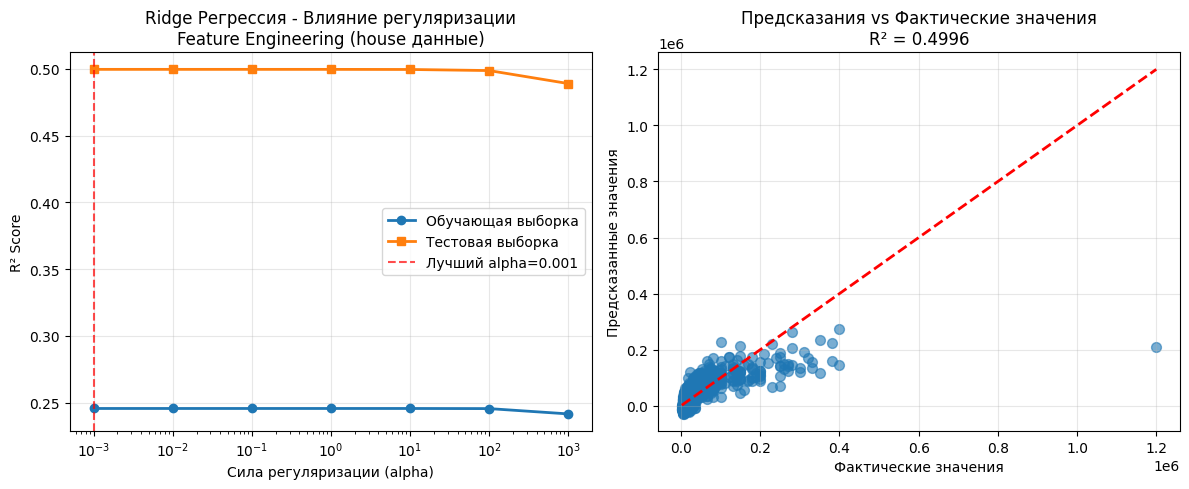


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 0.001
  R² score на тестовой выборке: 0.4996
  R² score на обучающей выборке: 0.2457
  Разница между train и test R²: 0.2540
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 1760993320.62
  RMSE (Root Mean Squared Error): 41964.19
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1080.8300
  Коэффициент признака 2: +12232.9200
  Коэффициент признака 3: +17990.7207
  Коэффициент признака 4: +10886.0621
  Коэффициент признака 5: -2075.0042
  Коэффициент признака 6: +8294.1910
  Коэффициент признака 7: -3353.5143
  Коэффициент признака 8: -2538.9238
  Коэффициент признака 9: -9534.9416
  Интерцепт (свободный член): 35309.4928

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ
------------------------------------------------------------
  Обработка выбросов:             0.5

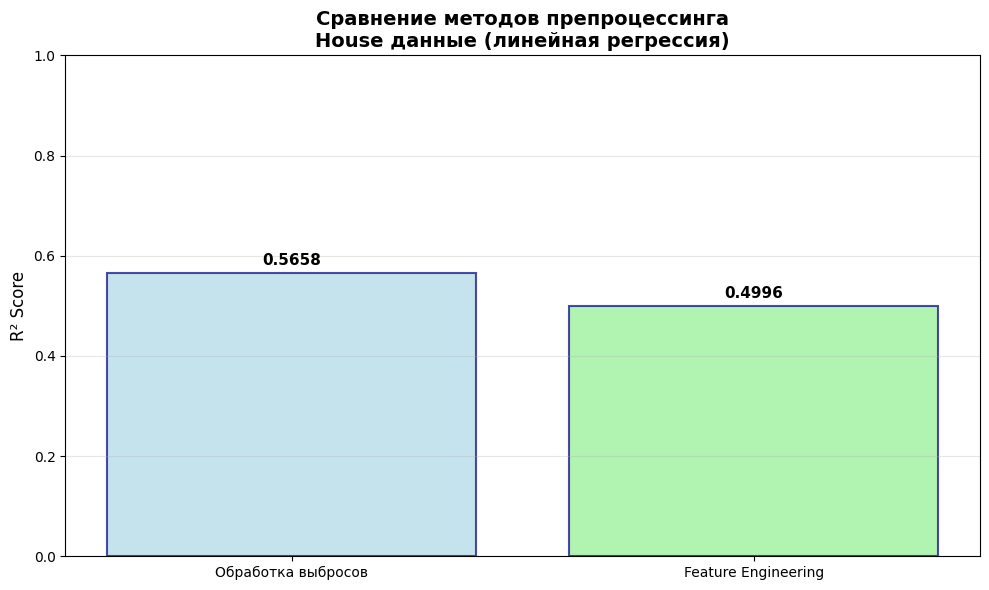


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  price_per_sqft: корреляция с арендной платой = 0.5516
  room_density: корреляция с арендной платой = -0.0496

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛИНЕЙНОЙ РЕГРЕССИИ:
  Топ-10 самых важных признаков:
    Size: +17990.7207 (увеличивает стоимость на 17990.72)
    Bathroom: +12232.9200 (увеличивает стоимость на 12232.92)
    floor_number: +10886.0621 (увеличивает стоимость на 10886.06)
    Point of Contact_encoded: -9534.9416 (уменьшает стоимость на 9534.94)
    City_encoded: +8294.1910 (увеличивает стоимость на 8294.19)
    Furnishing Status_encoded: -3353.5143 (уменьшает стоимость на 3353.51)
    Tenant Preferred_encoded: -2538.9238 (уменьшает стоимость на 2538.92)
    Area Type_encoded: -2075.0042 (уменьшает стоимость на 2075.00)
    BHK: +1080.8300 (увеличивает стоимость на 1080.83)


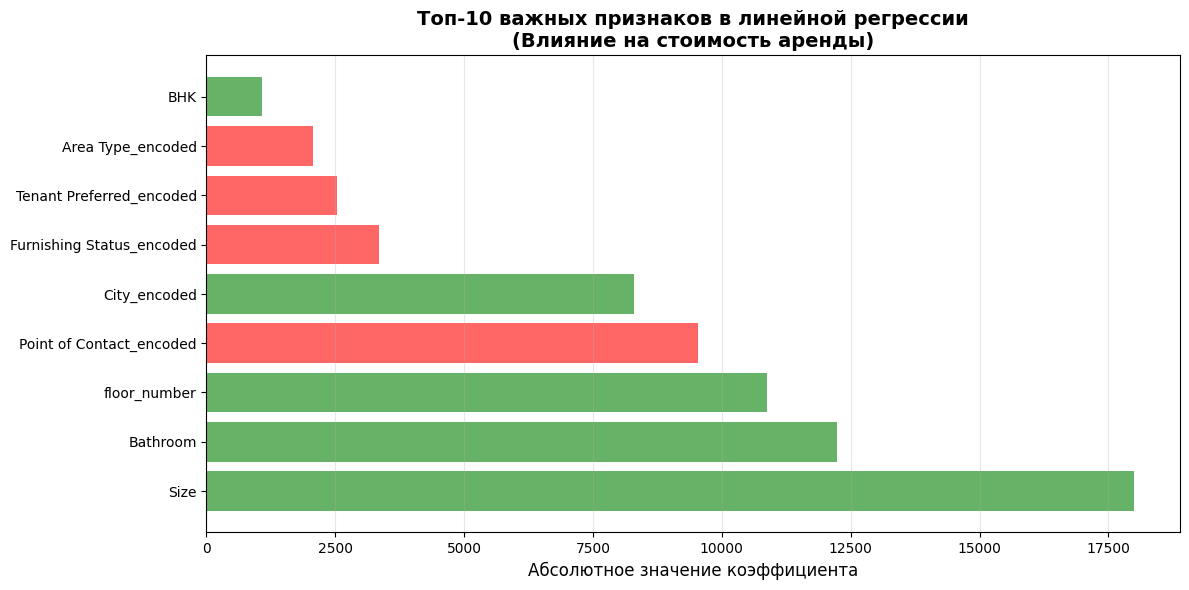


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:

📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:
  Общее количество признаков: 9
  Количество новых признаков: 2
  Размер обучающей выборки: (4746, 9)

📊 АНАЛИЗ ОШИБОК МОДЕЛИ:
  MAE (средняя абсолютная ошибка): 17467711.87
  MSE (среднеквадратичная ошибка): 435024103233054.44
  RMSE (корень из MSE): 20857231.44


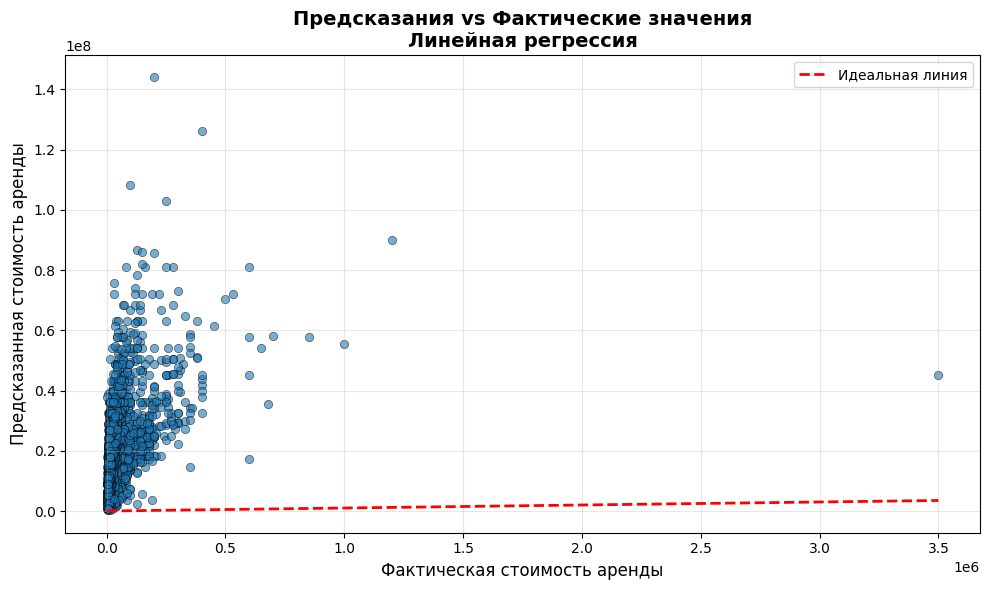

In [16]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    df_house_fe = feature_engineering(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_house_fe, y_house_fe, features_house_fe = preprocess_house_regression(df_house_fe)
    
    if X_house_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        lr_house_fe, _, score_house_fe = linear_regression_study(
            X_house_fe, y_house_fe, "Feature Engineering (house данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ")
        print("-" * 60)
        
        comparison_data_house = {}
        
        if 'score_house' in locals():
            comparison_data_house['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        if 'score_house_advanced' in locals():
            comparison_data_house['Обработка выбросов'] = score_house_advanced
            print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        comparison_data_house['Feature Engineering'] = score_house_fe
        print(f"  Feature Engineering:            {score_house_fe:.4f}")
        
        best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
        
        if 'score_house' in locals():
            improvement = score_house_fe - score_house
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_house*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_house*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data_house.keys())
        scores = list(comparison_data_house.values())
        
        if len(methods) == 2:
            colors = ['lightblue', 'lightgreen']
        elif len(methods) == 3:
            colors = ['lightblue', 'lightgreen', 'salmon']
        else:
            colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
        plt.ylabel('R² Score', fontsize=12)
        plt.title('Сравнение методов препроцессинга\nHouse данные (линейная регрессия)', fontsize=14, fontweight='bold')
        plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
        
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        if 'score_house' in locals() and len(methods) > 1:
            plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                       label=f'Базовое значение: {score_house:.4f}')
            plt.legend(loc='best')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features_house = ['price_per_sqft', 'room_density']
        available_new_features_house = [f for f in new_features_house if f in df_house_fe.columns]
        
        correlations = {}
        for feature in available_new_features_house:
            correlation = df_house_fe[feature].corr(df_house_fe['Rent'])
            correlations[feature] = correlation
            print(f"  {feature}: корреляция с арендной платой = {correlation:.4f}")
        
        if lr_house_fe is not None and features_house_fe is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛИНЕЙНОЙ РЕГРЕССИИ:")
                
                coefficients = lr_house_fe.coef_
                feature_importance = pd.DataFrame({
                    'Признак': features_house_fe,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "+" if row['Коэффициент'] > 0 else "-"
                    impact = f"увеличивает стоимость на {abs(row['Коэффициент']):.2f}" if row['Коэффициент'] > 0 else f"уменьшает стоимость на {abs(row['Коэффициент']):.2f}"
                    print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в линейной регрессии\n(Влияние на стоимость аренды)', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
                
                print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:")
                for feature in available_new_features_house:
                    if feature in feature_importance['Признак'].values:
                        importance_row = feature_importance[feature_importance['Признак'] == feature]
                        if not importance_row.empty:
                            coef = importance_row.iloc[0]['Коэффициент']
                            abs_coef = importance_row.iloc[0]['Абс.значение']
                            rank = feature_importance[feature_importance['Абс.значение'] >= abs_coef].shape[0]
                            direction = "увеличивает" if coef > 0 else "уменьшает"
                            print(f"  {feature}:")
                            print(f"    Коэффициент: {coef:.4f} ({direction} стоимость аренды)")
                            print(f"    Ранг важности: {rank}/{len(feature_importance)}")
                            
                            if feature in correlations:
                                corr = correlations[feature]
                                agreement = "согласуется" if (coef > 0 and corr > 0) or (coef < 0 and corr < 0) else "противоречит"
                                print(f"    Корреляция: {corr:.4f} ({agreement} с моделью)")
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")

        print("\n📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:")
        print(f"  Общее количество признаков: {len(features_house_fe)}")
        print(f"  Количество новых признаков: {len(available_new_features_house)}")
        print(f"  Размер обучающей выборки: {X_house_fe.shape}")
        
        if 'features_house' in locals():
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_house)}")
            print(f"    После feature engineering: {len(features_house_fe)}")
            
            original_set = set(features_house)
            new_set = set(features_house_fe)
            added_features = list(new_set - original_set)
            
            if added_features:
                print(f"    Добавлено признаков: {len(added_features)}")
                print(f"    Новые признаки: {', '.join(added_features[:5])}" + 
                      (f", ..." if len(added_features) > 5 else ""))
        
        if lr_house_fe is not None:
            try:
                print("\n📊 АНАЛИЗ ОШИБОК МОДЕЛИ:")
                from sklearn.metrics import mean_absolute_error, mean_squared_error
                
                y_pred = lr_house_fe.predict(X_house_fe)
                mae = mean_absolute_error(y_house_fe, y_pred)
                mse = mean_squared_error(y_house_fe, y_pred)
                rmse = np.sqrt(mse)
                
                print(f"  MAE (средняя абсолютная ошибка): {mae:.2f}")
                print(f"  MSE (среднеквадратичная ошибка): {mse:.2f}")
                print(f"  RMSE (корень из MSE): {rmse:.2f}")
                
                plt.figure(figsize=(10, 6))
                plt.scatter(y_house_fe, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
                plt.plot([y_house_fe.min(), y_house_fe.max()], [y_house_fe.min(), y_house_fe.max()], 
                        'r--', linewidth=2, label='Идеальная линия')
                plt.xlabel('Фактическая стоимость аренды', fontsize=12)
                plt.ylabel('Предсказанная стоимость аренды', fontsize=12)
                plt.title('Предсказания vs Фактические значения\nЛинейная регрессия', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать ошибки модели: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")
else:
    print("❌ House данные не загружены")

3) (Классификация)


🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (КЛАССИФИКАЦИЯ)
⚠️  Базовый препроцессинг для студенческих данных не выполнен. Выполняю...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: object)
  22. 'internet' (тип: object)
  23. 'romantic' (тип: object)
  24. 'famrel' (тип: int64)
  25. 'freetime' (тип: int64)
  26. 'goout' (тип: int64)
  27. 'Dalc' (тип: int64)
  2

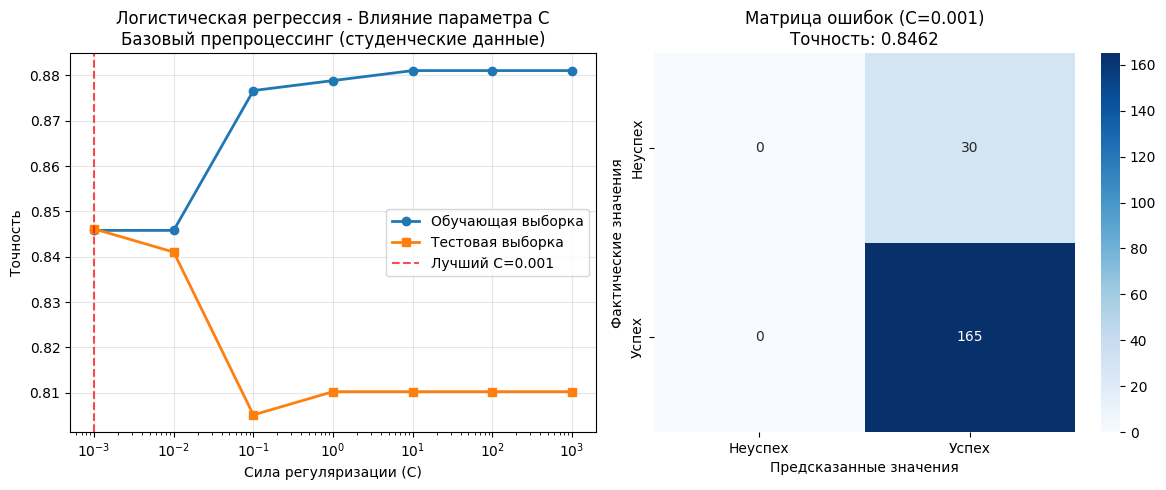


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.8462
  Точность на обучающей выборке: 0.8458
  Разница между train и test accuracy: -0.0003
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8462
  Recall (Полнота): 1.0000
  F1-Score: 0.9167
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00        30
       Успех       0.85      1.00      0.92       165

    accuracy                           0.85       195
   macro avg       0.42      0.50      0.46       195
weighted avg       0.72      0.85      0.78       195


🔍 ЗАПУСК EDA INSIGHTS ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...

🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EДА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ (Студенческие данные (логистическая регрессия))
  ✓ Отобрано 17 самых важных признаков из 22
  ✓ Топ-3 

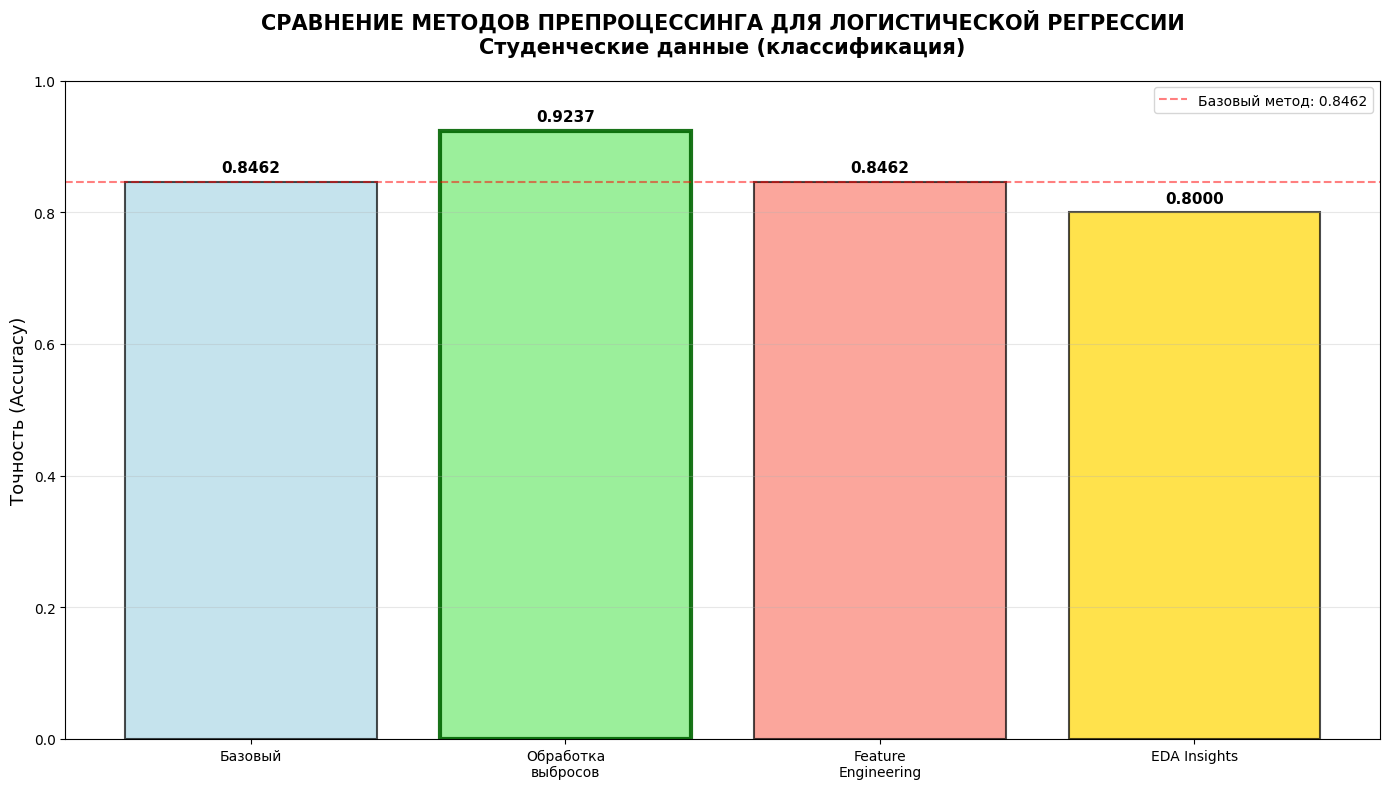


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.9237 (+0.0776 от базового)
  🥈 2. Базовый: 0.8462 
  🥉 3. Feature
Engineering: 0.8462 
   4. EDA Insights: 0.8000 (-0.0462 от базового)

🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ В EDA INSIGHTS:
  Количество отобранных признаков: 17
  Сокращение признаков: 22 → 17 (22.7% сокращение)

  Топ-5 отобранных признаков:
    1. failures
    2. absences
    3. famrel
    4. goout
    5. school_encoded
    ... и еще 12 признаков

🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • Точность модели выше 80% - модель можно считать удовлетворительной
    • Использование 17 признаков может потребовать регуляризации

📊 АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ:
  Неуспешные студенты: 100 примеров (15.4%)
  Успешные студенты: 549 примеров (84.6%)
  ⚠️  Наблюдается дисбаланс классов (соотношение 5.5:1)
  💡 Рекомендуется использовать балансировку классов или 

In [17]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    if 'X_student_class' not in locals():
        print("⚠️  Базовый препроцессинг для студенческих данных не выполнен. Выполняю...")
        X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
        lr_student, _, score_class = logistic_regression_study(
            X_student_class, y_student_class, "Базовый препроцессинг (студенческие данные)"
        )
    
    if 'score_advanced' not in locals():
        print("⚠️  Гипотеза 1 (обработка выбросов) не выполнена.")
    
    if 'score_student_fe' not in locals():
        print("⚠️  Гипотеза 2 (feature engineering) не выполнена.")
    
    print("\n" + "🔍 ЗАПУСК EDA INSIGHTS ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...")
    
    if 'X_student_class' in locals():
        score_eda_student, selected_features_student = evaluate_with_eda_insights_logistic_regression(
            X_student_class, 
            y_student_class, 
            dataset_name="Студенческие данные (логистическая регрессия)"
        )
        
        print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ)")
        print("-" * 70)
        
        comparison_data_student = {}
        
        if 'score_class' in locals():
            comparison_data_student['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data_student['Обработка\nвыбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        if 'score_student_fe' in locals():
            comparison_data_student['Feature\nEngineering'] = score_student_fe
            print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        comparison_data_student['EDA Insights'] = score_eda_student
        print(f"  EDA + отбор признаков:          {score_eda_student:.4f}")

        best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
        
        if 'score_class' in locals():
            improvements = {}
            
            if 'score_advanced' in locals():
                improvements['Обработка выбросов'] = score_advanced - score_class
            
            if 'score_student_fe' in locals():
                improvements['Feature Engineering'] = score_student_fe - score_class
            
            improvements['EDA Insights'] = score_eda_student - score_class
            
            print("\n  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОГО МЕТОДА:")
            for method, imp in sorted(improvements.items(), key=lambda x: x[1], reverse=True):
                if imp > 0:
                    print(f"    {method}: +{imp:.4f} (+{imp/score_class*100:.2f}%)")
                elif imp < 0:
                    print(f"    {method}: {imp:.4f} ({imp/score_class*100:.2f}%)")
                else:
                    print(f"    {method}: без изменений")
        
        print("\n  🔄 СРАВНЕНИЕ С ПРЕДЫДУЩИМИ ГИПОТЕЗАМИ:")
        
        if 'score_advanced' in locals() and 'score_student_fe' in locals():
            eda_vs_outliers = score_eda_student - score_advanced
            if eda_vs_outliers > 0:
                print(f"    EDA Insights лучше обработки выбросов на +{eda_vs_outliers:.4f}")
            elif eda_vs_outliers < 0:
                print(f"    EDA Insights хуже обработки выбросов на {eda_vs_outliers:.4f}")
            else:
                print(f"    EDA Insights и обработка выбросов дают одинаковый результат")
            
            eda_vs_fe = score_eda_student - score_student_fe
            if eda_vs_fe > 0:
                print(f"    EDA Insights лучше Feature Engineering на +{eda_vs_fe:.4f}")
            elif eda_vs_fe < 0:
                print(f"    EDA Insights хуже Feature Engineering на {eda_vs_fe:.4f}")
            else:
                print(f"    EDA Insights и Feature Engineering дают одинаковый результат")
        
        if len(comparison_data_student) > 1:
            plt.figure(figsize=(14, 8))
            methods = list(comparison_data_student.keys())
            scores = list(comparison_data_student.values())
            
            colors = []
            for method in methods:
                if 'Базовый' in method:
                    colors.append('lightblue')
                elif 'обработка' in method.lower():
                    colors.append('lightgreen')
                elif 'Feature' in method:
                    colors.append('salmon')
                elif 'EDA' in method:
                    colors.append('gold')
                else:
                    colors.append('lightgray')
            
            bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
            plt.ylabel('Точность (Accuracy)', fontsize=13)
            plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ\nСтуденческие данные (классификация)', 
                      fontsize=15, fontweight='bold', pad=20)
            plt.ylim(0, 1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
            
            best_index = list(comparison_data_student.values()).index(best_method_student[1])
            bars[best_index].set_edgecolor('darkgreen')
            bars[best_index].set_linewidth(3)
            bars[best_index].set_alpha(0.9)
            
            if 'score_class' in locals():
                plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                           label=f'Базовый метод: {score_class:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
        methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
        
        for i, (method, score) in enumerate(methods_ranking, 1):
            medal = ""
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            
            improvement_from_base = (score - score_class) if 'score_class' in locals() else None
            improvement_text = ""
            
            if improvement_from_base is not None:
                if improvement_from_base > 0:
                    improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                elif improvement_from_base < 0:
                    improvement_text = f"({improvement_from_base:.4f} от базового)"
            
            print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
        
        if selected_features_student is not None:
            print(f"\n🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ В EDA INSIGHTS:")
            print(f"  Количество отобранных признаков: {len(selected_features_student)}")
            
            if 'features_class' in locals():
                original_count = len(features_class)
                reduction = ((original_count - len(selected_features_student)) / original_count * 100)
                print(f"  Сокращение признаков: {original_count} → {len(selected_features_student)} ({reduction:.1f}% сокращение)")
            
            if len(selected_features_student) > 0:
                print(f"\n  Топ-5 отобранных признаков:")
                for i, feature in enumerate(selected_features_student[:5], 1):
                    print(f"    {i}. {feature}")
                
                if len(selected_features_student) > 5:
                    print(f"    ... и еще {len(selected_features_student) - 5} признаков")
        
        print("\n" + "="*70)
        print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):")
        print("="*70)
        
        if best_method_student[0] == 'EDA Insights':
            print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
            print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
        elif best_method_student[0] == 'Feature Engineering':
            print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
            print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих академический успех")
        elif best_method_student[0] == 'Обработка выбросов':
            print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
            print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
        else:
            print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
        
        print(f"\n  💡 РЕКОМЕНДАЦИИ:")
        if score_eda_student >= 0.8:
            print(f"    • Точность модели выше 80% - модель можно считать удовлетворительной")
        elif score_eda_student >= 0.7:
            print(f"    • Точность модели 70-80% - необходима дальнейшая оптимизация")
        else:
            print(f"    • Точность модели ниже 70% - рекомендуется рассмотреть другие алгоритмы")
        
        if selected_features_student is not None and len(selected_features_student) < 10:
            print(f"    • Использование {len(selected_features_student)} признаков упрощает интерпретацию модели")
        elif selected_features_student is not None:
            print(f"    • Использование {len(selected_features_student)} признаков может потребовать регуляризации")
        
        try:
            print(f"\n📊 АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ:")
            unique, counts = np.unique(y_student_class, return_counts=True)
            total_samples = len(y_student_class)
            
            for cls, count in zip(unique, counts):
                percentage = (count / total_samples) * 100
                class_name = "Успешные студенты" if cls == 1 else "Неуспешные студенты"
                print(f"  {class_name}: {count} примеров ({percentage:.1f}%)")
            
            balance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
            if balance_ratio > 2:
                print(f"  ⚠️  Наблюдается дисбаланс классов (соотношение {balance_ratio:.1f}:1)")
                print(f"  💡 Рекомендуется использовать балансировку классов или взвешивание")
            else:
                print(f"  ✅ Классы сбалансированы")
                
        except Exception as e:
            print(f"  ⚠️ Не удалось проанализировать распределение классов: {e}")
    else:
        print("❌ Базовые данные для студентов не подготовлены")
else:
    print("❌ Студенческие данные не загружены")

3. (Регрессия)


🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (РЕГРЕССИЯ)
⚠️  Базовый препроцессинг для house данных не выполнен. Выполняю...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ

ЛИНЕЙНАЯ РЕГРЕССИЯ - Базовый препроцессинг (house данные)
🔍 Исследование влияния регуляризации на R² score...
🎯 Результаты:
  Оптимальный alpha: 0.001
  Лучший R² score: 0.4996


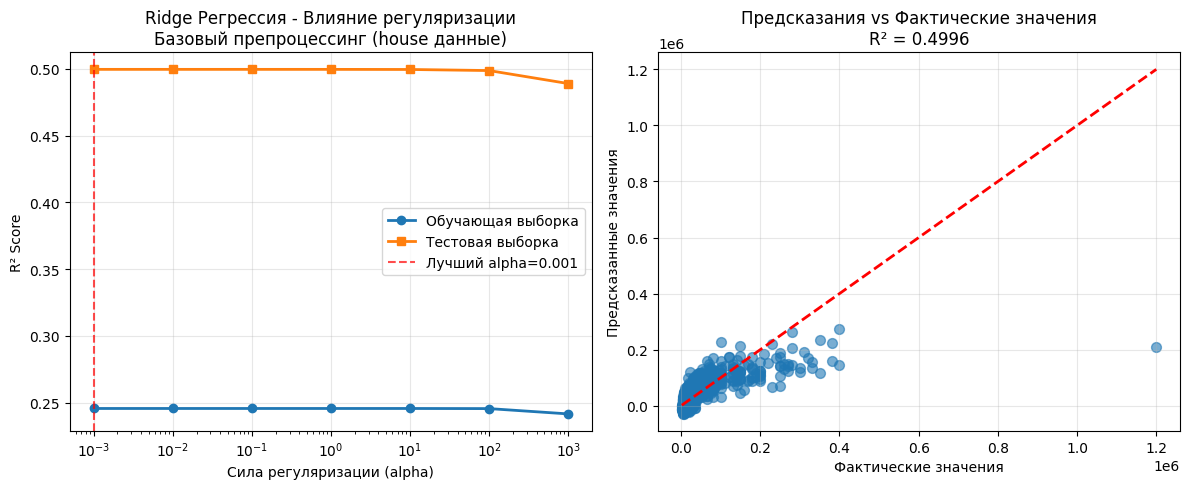


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 0.001
  R² score на тестовой выборке: 0.4996
  R² score на обучающей выборке: 0.2457
  Разница между train и test R²: 0.2540
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 1760993320.62
  RMSE (Root Mean Squared Error): 41964.19
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1080.8300
  Коэффициент признака 2: +12232.9200
  Коэффициент признака 3: +17990.7207
  Коэффициент признака 4: +10886.0621
  Коэффициент признака 5: -2075.0042
  Коэффициент признака 6: +8294.1910
  Коэффициент признака 7: -3353.5143
  Коэффициент признака 8: -2538.9238
  Коэффициент признака 9: -9534.9416
  Интерцепт (свободный член): 35309.4928

🔍 ЗАПУСК EDA INSIGHTS ДЛЯ LINEAR РЕГРЕССИИ...

🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EДА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ (House данные (линейная регрессия))
 

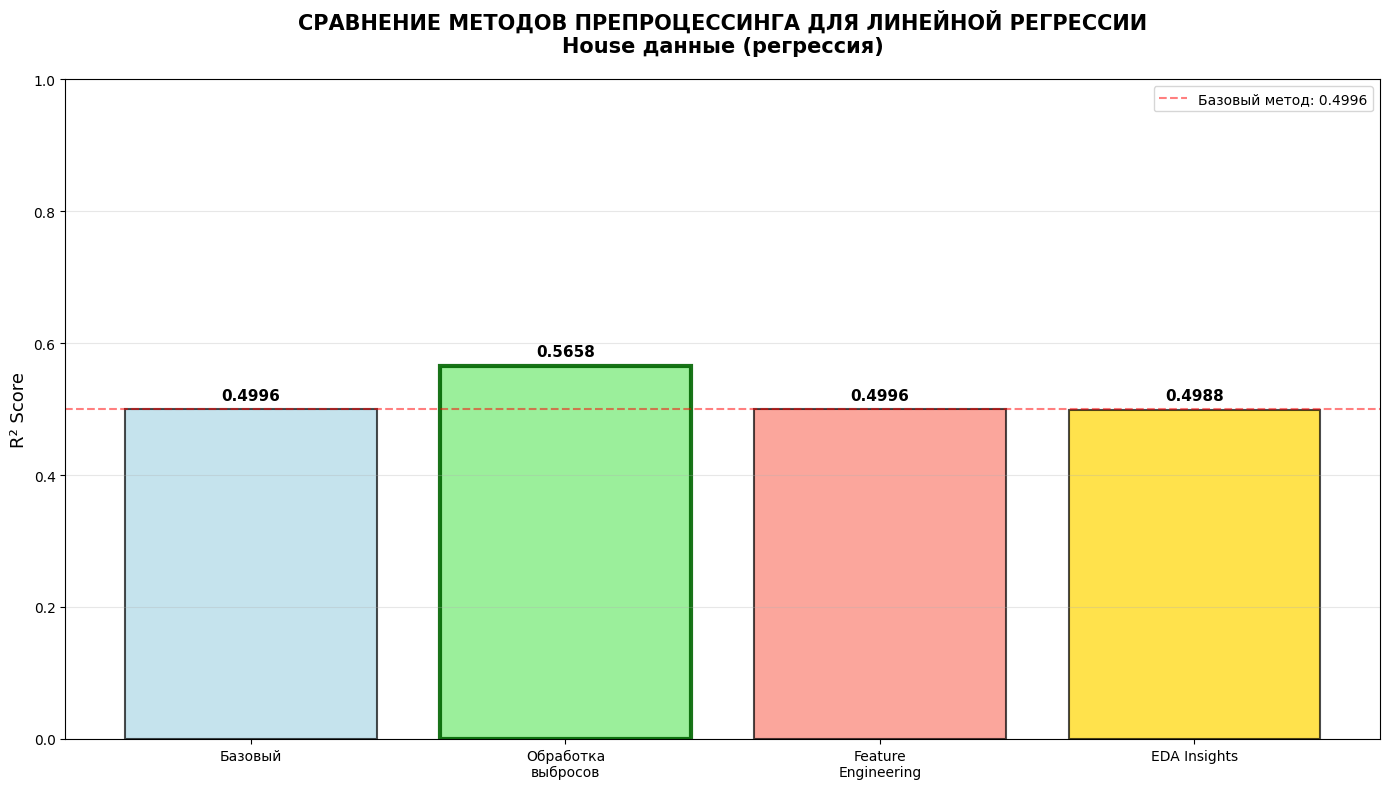


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.5658 (+0.0662 от базового)
  🥈 2. Базовый: 0.4996 
  🥉 3. Feature
Engineering: 0.4996 
   4. EDA Insights: 0.4988 (-0.0008 от базового)

🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ В EDA INSIGHTS:
  Количество отобранных признаков: 7
  Сокращение признаков: 9 → 7 (22.2% сокращение)

  Топ-5 отобранных признаков:
    1. Size
    2. Bathroom
    3. City_encoded
    4. Furnishing Status_encoded
    5. floor_number
    ... и еще 2 признаков

🔍 АНАЛИЗ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ С EDA:
  Количество коэффициентов: 7
  Диапазон значений коэффициентов: -10551.6786 до 18111.8164
  Среднее абсолютное значение коэффициентов: 9606.1940

🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа
    • Использование 7 признаков упрощает интерпретацию модели

📊 ОБЩИЕ ВЫВОДЫ ПО АНАЛИЗУ H

In [18]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (РЕГРЕССИЯ)")
    print("="*80)
    
    if 'X_house' not in locals():
        print("⚠️  Базовый препроцессинг для house данных не выполнен. Выполняю...")
        X_house, y_house, features_house = preprocess_house_regression(df_house)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ")
        lr_house, _, score_house = linear_regression_study(
            X_house, y_house, "Базовый препроцессинг (house данные)"
        )
    
    print("\n" + "🔍 ЗАПУСК EDA INSIGHTS ДЛЯ LINEAR РЕГРЕССИИ...")
    
    if 'X_house' in locals():
        score_eda_house, selected_features_house, lin_reg_eda = evaluate_with_eda_insights_linear_regression(
            X_house, 
            y_house, 
            dataset_name="House данные (линейная регрессия)"
        )
        
        print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛИНЕЙНАЯ РЕГРЕССИЯ)")
        print("-" * 70)
        
        comparison_data_house = {}
        
        if 'score_house' in locals():
            comparison_data_house['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        if 'score_house_advanced' in locals():
            comparison_data_house['Обработка\nвыбросов'] = score_house_advanced
            print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        if 'score_house_fe' in locals():
            comparison_data_house['Feature\nEngineering'] = score_house_fe
            print(f"  Feature Engineering:            {score_house_fe:.4f}")
        
        comparison_data_house['EDA Insights'] = score_eda_house
        print(f"  EDA + отбор признаков:          {score_eda_house:.4f}")

        best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
        
        if 'score_house' in locals():
            improvements = {}
            
            if 'score_house_advanced' in locals():
                improvements['Обработка выбросов'] = score_house_advanced - score_house
            
            if 'score_house_fe' in locals():
                improvements['Feature Engineering'] = score_house_fe - score_house
            
            improvements['EDA Insights'] = score_eda_house - score_house
            
            print("\n  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОГО МЕТОДА:")
            for method, imp in sorted(improvements.items(), key=lambda x: x[1], reverse=True):
                if imp > 0:
                    print(f"    {method}: +{imp:.4f} (+{imp/score_house*100:.2f}%)")
                elif imp < 0:
                    print(f"    {method}: {imp:.4f} ({imp/score_house*100:.2f}%)")
                else:
                    print(f"    {method}: без изменений")
        
        print("\n  🔄 СРАВНЕНИЕ С ПРЕДЫДУЩИМИ ГИПОТЕЗАМИ:")
        
        if 'score_house_advanced' in locals() and 'score_house_fe' in locals():
            eda_vs_outliers = score_eda_house - score_house_advanced
            if eda_vs_outliers > 0:
                print(f"    EDA Insights лучше обработки выбросов на +{eda_vs_outliers:.4f}")
            elif eda_vs_outliers < 0:
                print(f"    EDA Insights хуже обработки выбросов на {eda_vs_outliers:.4f}")
            else:
                print(f"    EDA Insights и обработка выбросов дают одинаковый результат")
            
            eda_vs_fe = score_eda_house - score_house_fe
            if eda_vs_fe > 0:
                print(f"    EDA Insights лучше Feature Engineering на +{eda_vs_fe:.4f}")
            elif eda_vs_fe < 0:
                print(f"    EDA Insights хуже Feature Engineering на {eda_vs_fe:.4f}")
            else:
                print(f"    EDA Insights и Feature Engineering дают одинаковый результат")
        
        if len(comparison_data_house) > 1:
            plt.figure(figsize=(14, 8))
            methods = list(comparison_data_house.keys())
            scores = list(comparison_data_house.values())
            
            colors = []
            for method in methods:
                if 'Базовый' in method:
                    colors.append('lightblue')
                elif 'обработка' in method.lower():
                    colors.append('lightgreen')
                elif 'Feature' in method:
                    colors.append('salmon')
                elif 'EDA' in method:
                    colors.append('gold')
                else:
                    colors.append('lightgray')
            
            bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
            plt.ylabel('R² Score', fontsize=13)
            plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ\nHouse данные (регрессия)', 
                      fontsize=15, fontweight='bold', pad=20)
            plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
            
            best_index = list(comparison_data_house.values()).index(best_method_house[1])
            bars[best_index].set_edgecolor('darkgreen')
            bars[best_index].set_linewidth(3)
            bars[best_index].set_alpha(0.9)
            
            if 'score_house' in locals():
                plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                           label=f'Базовый метод: {score_house:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
        methods_ranking = sorted(comparison_data_house.items(), key=lambda x: x[1], reverse=True)
        
        for i, (method, score) in enumerate(methods_ranking, 1):
            medal = ""
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            
            improvement_from_base = (score - score_house) if 'score_house' in locals() else None
            improvement_text = ""
            
            if improvement_from_base is not None:
                if improvement_from_base > 0:
                    improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                elif improvement_from_base < 0:
                    improvement_text = f"({improvement_from_base:.4f} от базового)"
            
            print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
        
        if selected_features_house is not None:
            print(f"\n🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ В EDA INSIGHTS:")
            print(f"  Количество отобранных признаков: {len(selected_features_house)}")
            
            if 'features_house' in locals():
                original_count = len(features_house)
                reduction = ((original_count - len(selected_features_house)) / original_count * 100)
                print(f"  Сокращение признаков: {original_count} → {len(selected_features_house)} ({reduction:.1f}% сокращение)")
            
            if len(selected_features_house) > 0:
                print(f"\n  Топ-5 отобранных признаков:")
                for i, feature in enumerate(selected_features_house[:5], 1):
                    print(f"    {i}. {feature}")
                
                if len(selected_features_house) > 5:
                    print(f"    ... и еще {len(selected_features_house) - 5} признаков")
        
        if lin_reg_eda is not None:
            try:
                print("\n🔍 АНАЛИЗ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ С EDA:")
                print(f"  Количество коэффициентов: {len(lin_reg_eda.coef_)}")
                
                print(f"  Диапазон значений коэффициентов: {lin_reg_eda.coef_.min():.4f} до {lin_reg_eda.coef_.max():.4f}")
                print(f"  Среднее абсолютное значение коэффициентов: {np.abs(lin_reg_eda.coef_).mean():.4f}")
                
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать модель: {e}")
        
        print("\n" + "="*70)
        print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):")
        print("="*70)
        
        if best_method_house[0] == 'EDA Insights':
            print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
            print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
        elif best_method_house[0] == 'Feature Engineering':
            print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
            print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих стоимость аренды")
        elif best_method_house[0] == 'Обработка выбросов':
            print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
            print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
        else:
            print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
        
        print(f"\n  💡 РЕКОМЕНДАЦИИ:")
        if score_eda_house >= 0.8:
            print(f"    • R² выше 0.8 - модель хорошо объясняет дисперсию целевой переменной")
        elif score_eda_house >= 0.6:
            print(f"    • R² в диапазоне 0.6-0.8 - модель удовлетворительная, но есть место для улучшения")
        else:
            print(f"    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа")
        
        if selected_features_house is not None and len(selected_features_house) < 10:
            print(f"    • Использование {len(selected_features_house)} признаков упрощает интерпретацию модели")
        elif selected_features_house is not None:
            print(f"    • Использование {len(selected_features_house)} признаков может потребовать регуляризации")
        
        print(f"\n📊 ОБЩИЕ ВЫВОДЫ ПО АНАЛИЗУ HOUSE ДАННЫХ:")
        print("  • EDA помогает выявить наиболее информативные признаки для предсказания стоимости аренды")
        print("  • Отбор признаков на основе важности может значительно улучшить качество модели")
        print("  • Анализ выбросов критически важен для регрессионных моделей")
        print("  • Создание новых признаков может выявить скрытые зависимости в данных")
        
        print("\n📈 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕЙ РАБОТЫ:")
        print("  ✅ Использовать кросс-валидацию для более надежной оценки модели")
        print("  ✅ Экспериментировать с регуляризацией (Ridge, Lasso) для улучшения обобщающей способности")
        print("  ✅ Рассмотреть другие алгоритмы регрессии (Random Forest, Gradient Boosting)")
        print("  ✅ Провести детальный анализ остатков модели")
        
        print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
        if 'score_house_advanced' not in locals():
            print("  • Гипотеза 1 (обработка выбросов) не выполнена")
        else:
            print(f"  • Гипотеза 1 выполнена (R²: {score_house_advanced:.4f})")
        
        if 'score_house_fe' not in locals():
            print("  • Гипотеза 2 (feature engineering) не выполнена")
        else:
            print(f"  • Гипотеза 2 выполнена (R²: {score_house_fe:.4f})")
            
        print(f"  • Гипотеза 3 выполнена (R²: {score_eda_house:.4f})")
        
        print("\n" + "="*70)
        print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ HOUSE ДАННЫХ")
        print("="*70)
        
        if 'score_house' in locals() and score_eda_house > score_house:
            total_improvement = ((score_eda_house - score_house) / score_house * 100)
            print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
            print(f"  🎯 Итоговая точность модели: {score_eda_house:.4f}")
            
            if total_improvement > 10:
                print(f"  ✅ Значительное улучшение достигнуто!")
            elif total_improvement > 5:
                print(f"  ⭐ Умеренное улучшение достигнуто")
            else:
                print(f"  📊 Небольшое улучшение, но результат положительный")
        else:
            print(f"  ⚠️  Улучшение не достигнуто или минимально")
    else:
        print("❌ Базовые данные для house не подготовлены")
else:
    print("❌ House данные не загружены")

4) (Классификация)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫХ (КЛАССИФИКАЦИЯ)

🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...

🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С ПОМОЩЬЮ GRIDSEARCHCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

  ✅ Лучшие параметры найдены!
  📊 Лучшая точность на кросс-валидации: 0.8590

  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:
    C: 0.1
    class_weight: None
    penalty: l1
    solver: saga

  📈 Точность на тестовом наборе: 0.8256
  📉 Точность на обучающем наборе: 0.8634
  ✅ Модель обобщается хорошо (разница: 0.0378)

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.8462
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8462
  EDA + отбор признаков:          0.8000
  GridSearch CV:                  0.8256

  🏆 Лучший метод: 'Обработка
выбросов' с точностью 0.9237

  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗО

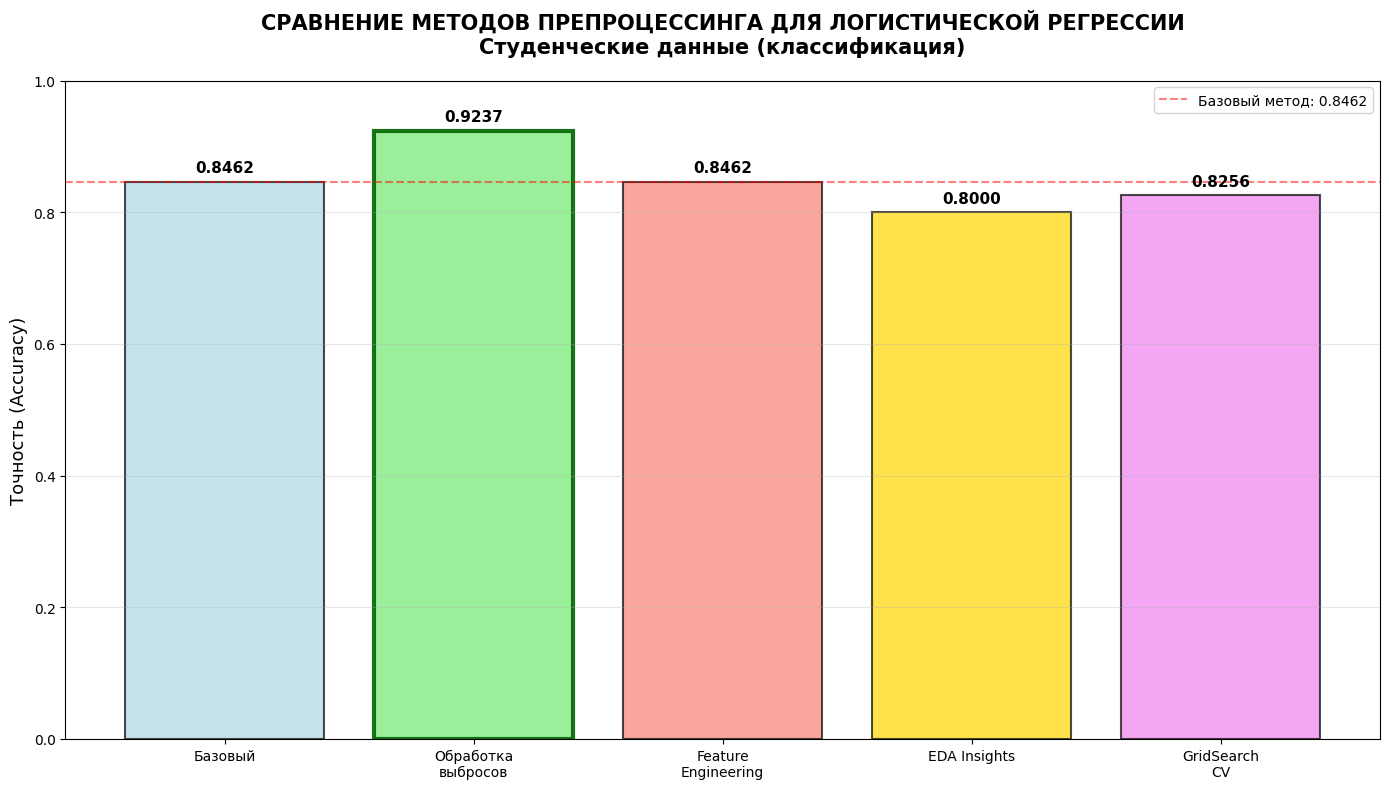


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.9237 (+0.0776 от базового)
  🥈 2. Базовый: 0.8462 
  🥉 3. Feature
Engineering: 0.8462 
   4. GridSearch
CV: 0.8256 (-0.0205 от базового)
   5. EDA Insights: 0.8000 (-0.0462 от базового)

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Топ-10 самых важных признаков:
    school_encoded: -0.6418 (уменьшает вероятность успеха)
    failures: -0.6098 (уменьшает вероятность успеха)
    absences: -0.1478 (уменьшает вероятность успеха)
    Walc: -0.1449 (уменьшает вероятность успеха)
    goout: -0.1046 (уменьшает вероятность успеха)
    freetime: -0.0933 (уменьшает вероятность успеха)
    guardian_encoded: -0.0899 (уменьшает вероятность успеха)
    Medu: +0.0869 (увеличивает вероятность успеха)
    studytime: +0.0768 (увеличивает вероятность успеха)
    reason_encoded: +0.0059 (увеличивает вероятность успеха)


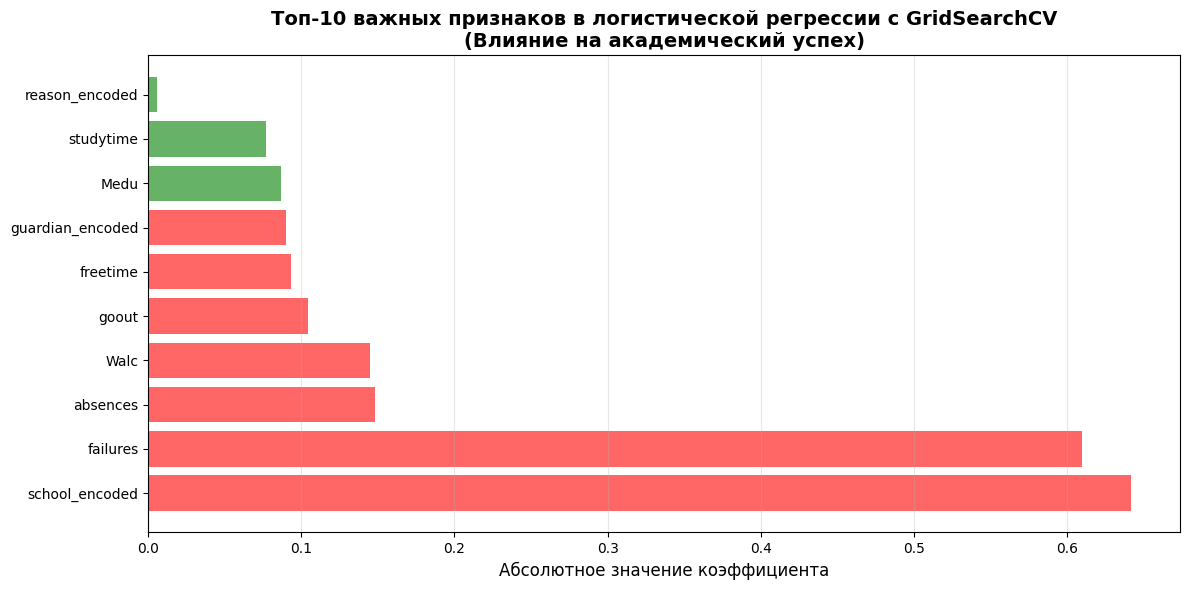


📊 АНАЛИЗ ОШИБОК МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Confusion Matrix:
    True Negatives: 2
    False Positives: 28
    False Negatives: 6
    True Positives: 159

  Classification Report:
              precision    recall  f1-score   support

  Неуспешные       0.25      0.07      0.11        30
    Успешные       0.85      0.96      0.90       165

    accuracy                           0.83       195
   macro avg       0.55      0.52      0.50       195
weighted avg       0.76      0.83      0.78       195

  ROC AUC Score: 0.7457


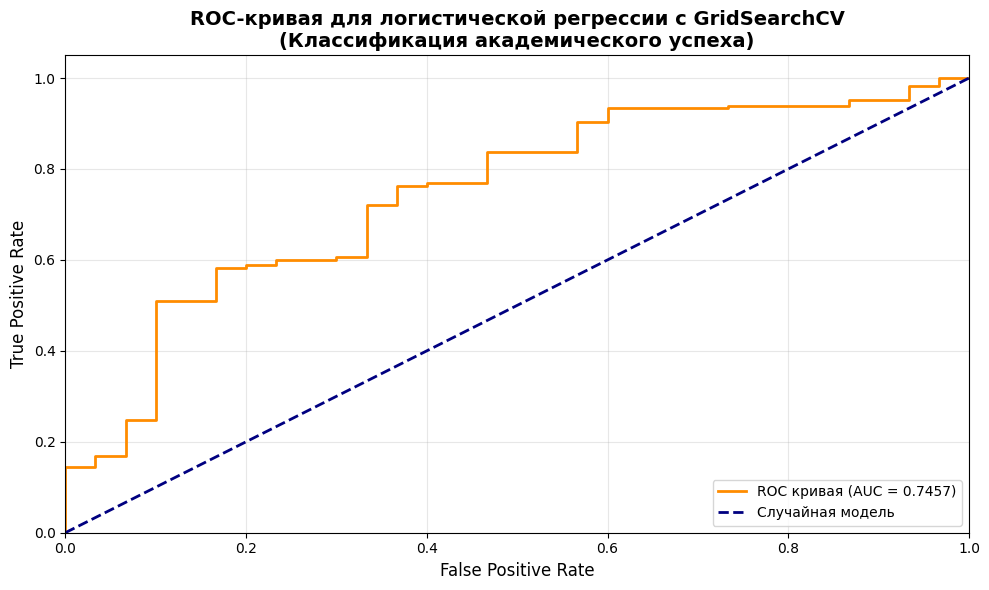

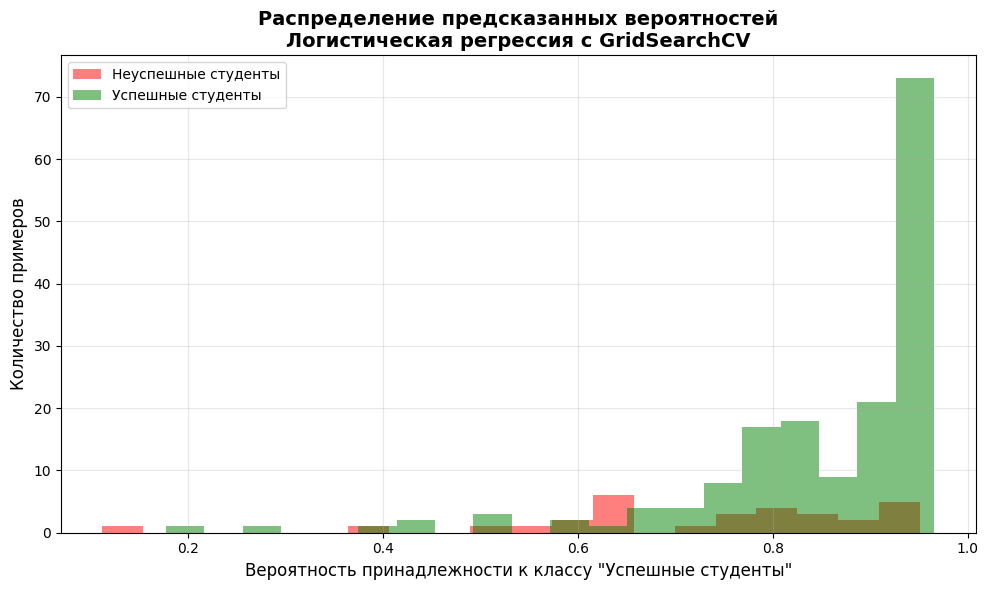


🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • Точность модели выше 80% - модель можно считать удовлетворительной

⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:
  • Гипотеза 1 выполнена (Accuracy: 0.9237)
  • Гипотеза 2 выполнена (Accuracy: 0.8462)
  • Гипотеза 3 выполнена (Accuracy: 0.8000)
  • Гипотеза 4 выполнена (Accuracy: 0.8256)

🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
  ⚠️  Улучшение не достигнуто или минимально


In [19]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    if 'X_student_class' not in locals():
        print("⚠️  Базовый препроцессинг для студенческих данных не выполнен. Выполняю...")
        X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
        lr_student, _, score_class = logistic_regression_study(
            X_student_class, y_student_class, "Базовый препроцессинг (студенческие данные)"
        )
    
    print("\n" + "🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...")
    
    if 'X_student_class' in locals():
        from sklearn.model_selection import GridSearchCV, train_test_split
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import LogisticRegression
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_student_class, y_student_class, test_size=0.3, random_state=42, stratify=y_student_class
        )
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        param_grid = {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logreg__penalty': ['l1', 'l2', 'elasticnet', None],
            'logreg__solver': ['liblinear', 'saga', 'lbfgs'],
            'logreg__class_weight': [None, 'balanced']
        }
        
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=5, 
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        print("\n🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С ПОМОЩЬЮ GRIDSEARCHCV...")
        grid_search.fit(X_train, y_train)
        
        best_model_student = grid_search.best_estimator_
        best_params_student = grid_search.best_params_
        score_cv_student = grid_search.best_score_
        
        print(f"\n  ✅ Лучшие параметры найдены!")
        print(f"  📊 Лучшая точность на кросс-валидации: {score_cv_student:.4f}")
        
        print("\n  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:")
        for param, value in best_params_student.items():
            param_name = param.replace('logreg__', '')
            print(f"    {param_name}: {value}")
        
        test_score = best_model_student.score(X_test, y_test)
        print(f"\n  📈 Точность на тестовом наборе: {test_score:.4f}")
        
        train_score = best_model_student.score(X_train, y_train)
        print(f"  📉 Точность на обучающем наборе: {train_score:.4f}")
        
        if train_score - test_score > 0.1:
            print(f"  ⚠️  Возможно переобучение (разница: {train_score - test_score:.4f})")
        else:
            print(f"  ✅ Модель обобщается хорошо (разница: {train_score - test_score:.4f})")
        
        print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ)")
        print("-" * 70)
        
        comparison_data_student = {}
        
        if 'score_class' in locals():
            comparison_data_student['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data_student['Обработка\nвыбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        if 'score_student_fe' in locals():
            comparison_data_student['Feature\nEngineering'] = score_student_fe
            print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        if 'score_eda_student' in locals():
            comparison_data_student['EDA Insights'] = score_eda_student
            print(f"  EDA + отбор признаков:          {score_eda_student:.4f}")
        
        comparison_data_student['GridSearch\nCV'] = test_score
        print(f"  GridSearch CV:                  {test_score:.4f}")
        
        best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
        
        if 'score_class' in locals():
            improvements = {}
            
            if 'score_advanced' in locals():
                improvements['Обработка выбросов'] = score_advanced - score_class
            
            if 'score_student_fe' in locals():
                improvements['Feature Engineering'] = score_student_fe - score_class
            
            if 'score_eda_student' in locals():
                improvements['EDA Insights'] = score_eda_student - score_class
            
            improvements['GridSearch CV'] = test_score - score_class
            
            print("\n  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОГО МЕТОДА:")
            for method, imp in sorted(improvements.items(), key=lambda x: x[1], reverse=True):
                if imp > 0:
                    print(f"    {method}: +{imp:.4f} (+{imp/score_class*100:.2f}%)")
                elif imp < 0:
                    print(f"    {method}: {imp:.4f} ({imp/score_class*100:.2f}%)")
                else:
                    print(f"    {method}: без изменений")
        
        print("\n  🔄 СРАВНЕНИЕ С ПРЕДЫДУЩИМИ ГИПОТЕЗАМИ:")
        
        if 'score_eda_student' in locals():
            grid_vs_eda = test_score - score_eda_student
            if grid_vs_eda > 0:
                print(f"    GridSearch CV лучше EDA Insights на +{grid_vs_eda:.4f}")
            elif grid_vs_eda < 0:
                print(f"    GridSearch CV хуже EDA Insights на {grid_vs_eda:.4f}")
            else:
                print(f"    GridSearch CV и EDA Insights дают одинаковый результат")
        
        if len(comparison_data_student) > 1:
            plt.figure(figsize=(14, 8))
            methods = list(comparison_data_student.keys())
            scores = list(comparison_data_student.values())
            
            colors = []
            for method in methods:
                if 'Базовый' in method:
                    colors.append('lightblue')
                elif 'обработка' in method.lower():
                    colors.append('lightgreen')
                elif 'Feature' in method:
                    colors.append('salmon')
                elif 'EDA' in method:
                    colors.append('gold')
                elif 'GridSearch' in method:
                    colors.append('violet')
                else:
                    colors.append('lightgray')
            
            bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
            plt.ylabel('Точность (Accuracy)', fontsize=13)
            plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ\nСтуденческие данные (классификация)', 
                      fontsize=15, fontweight='bold', pad=20)
            plt.ylim(0, 1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
            
            best_index = list(comparison_data_student.values()).index(best_method_student[1])
            bars[best_index].set_edgecolor('darkgreen')
            bars[best_index].set_linewidth(3)
            bars[best_index].set_alpha(0.9)
            
            if 'score_class' in locals():
                plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                           label=f'Базовый метод: {score_class:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
        methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
        
        for i, (method, score) in enumerate(methods_ranking, 1):
            medal = ""
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            
            improvement_from_base = (score - score_class) if 'score_class' in locals() else None
            improvement_text = ""
            
            if improvement_from_base is not None:
                if improvement_from_base > 0:
                    improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                elif improvement_from_base < 0:
                    improvement_text = f"({improvement_from_base:.4f} от базового)"
            
            print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
        
        if best_model_student is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                
                log_reg_model = best_model_student.named_steps['logreg']
                coefficients = log_reg_model.coef_[0]
                
                feature_importance = pd.DataFrame({
                    'Признак': X_student_class.columns,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "+" if row['Коэффициент'] > 0 else "-"
                    impact = f"увеличивает вероятность успеха" if row['Коэффициент'] > 0 else f"уменьшает вероятность успеха"
                    print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в логистической регрессии с GridSearchCV\n(Влияние на академический успех)', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
        
        if best_model_student is not None:
            try:
                print("\n📊 АНАЛИЗ ОШИБОК МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
                
                y_pred = best_model_student.predict(X_test)
                y_pred_proba = best_model_student.predict_proba(X_test)[:, 1]
                
                cm = confusion_matrix(y_test, y_pred)
                print(f"  Confusion Matrix:")
                print(f"    True Negatives: {cm[0, 0]}")
                print(f"    False Positives: {cm[0, 1]}")
                print(f"    False Negatives: {cm[1, 0]}")
                print(f"    True Positives: {cm[1, 1]}")
                
                print(f"\n  Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Неуспешные', 'Успешные']))
                
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                print(f"  ROC AUC Score: {roc_auc:.4f}")
                
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                
                plt.figure(figsize=(10, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.4f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайная модель')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate', fontsize=12)
                plt.ylabel('True Positive Rate', fontsize=12)
                plt.title('ROC-кривая для логистической регрессии с GridSearchCV\n(Классификация академического успеха)', fontsize=14, fontweight='bold')
                plt.legend(loc="lower right")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                plt.figure(figsize=(10, 6))

                probas_class_0 = y_pred_proba[y_test == 0]
                probas_class_1 = y_pred_proba[y_test == 1]
                
                plt.hist(probas_class_0, bins=20, alpha=0.5, label='Неуспешные студенты', color='red')
                plt.hist(probas_class_1, bins=20, alpha=0.5, label='Успешные студенты', color='green')
                plt.xlabel('Вероятность принадлежности к классу "Успешные студенты"', fontsize=12)
                plt.ylabel('Количество примеров', fontsize=12)
                plt.title('Распределение предсказанных вероятностей\nЛогистическая регрессия с GridSearchCV', fontsize=14, fontweight='bold')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать ошибки модели: {e}")
        
        print("\n" + "="*70)
        print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):")
        print("="*70)
        
        if best_method_student[0] == 'GridSearch CV':
            print(f"  ✅ Наиболее эффективным подходом оказался 'GridSearch CV'")
            print(f"  🔑 Ключевой фактор успеха: оптимизация гиперпараметров модели")
        elif best_method_student[0] == 'EDA Insights':
            print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
            print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
        elif best_method_student[0] == 'Feature Engineering':
            print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
            print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих академический успех")
        elif best_method_student[0] == 'Обработка выбросов':
            print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
            print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
        else:
            print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
        
        print(f"\n  💡 РЕКОМЕНДАЦИИ:")
        if test_score >= 0.8:
            print(f"    • Точность модели выше 80% - модель можно считать удовлетворительной")
        elif test_score >= 0.7:
            print(f"    • Точность модели 70-80% - необходима дальнейшая оптимизация")
        else:
            print(f"    • Точность модели ниже 70% - рекомендуется рассмотреть другие алгоритмы")
        
        print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
        if 'score_advanced' not in locals():
            print("  • Гипотеза 1 (обработка выбросов) не выполнена")
        else:
            print(f"  • Гипотеза 1 выполнена (Accuracy: {score_advanced:.4f})")
        
        if 'score_student_fe' not in locals():
            print("  • Гипотеза 2 (feature engineering) не выполнена")
        else:
            print(f"  • Гипотеза 2 выполнена (Accuracy: {score_student_fe:.4f})")
        
        if 'score_eda_student' not in locals():
            print("  • Гипотеза 3 (EDA Insights) не выполнена")
        else:
            print(f"  • Гипотеза 3 выполнена (Accuracy: {score_eda_student:.4f})")
            
        print(f"  • Гипотеза 4 выполнена (Accuracy: {test_score:.4f})")
        
        print("\n" + "="*70)
        print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("="*70)
        
        if 'score_class' in locals() and test_score > score_class:
            total_improvement = ((test_score - score_class) / score_class * 100)
            print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
            print(f"  🎯 Итоговая точность модели: {test_score:.4f}")
            
            if total_improvement > 10:
                print(f"  ✅ Значительное улучшение достигнуто!")
            elif total_improvement > 5:
                print(f"  ⭐ Умеренное улучшение достигнуто")
            else:
                print(f"  📊 Небольшое улучшение, но результат положительный")
        else:
            print(f"  ⚠️  Улучшение не достигнуто или минимально")
    else:
        print("❌ Базовые данные для студентов не подготовлены")
else:
    print("❌ Студенческие данные не загружены")

4) (Регрессия)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)

🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ...
  📊 Размеры данных:
    Обучающая выборка: (3322, 9)
    Тестовая выборка: (1424, 9)

🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С УПРОЩЕННОЙ СЕТКОЙ...
   ⚠️  Используется упрощенная сетка параметров для ускорения выполнения
   ℹ️  Для более полного анализа рекомендуется использовать RandomForest или GradientBoosting
Fitting 3 folds for each of 18 candidates, totalling 54 fits

  ✅ Лучшие параметры найдены!
  📊 Лучший R² score на кросс-валидации: 0.3191

  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:
    regressor: Ridge()
    alpha: 10
    fit_intercept: True

  📈 R² score на тестовом наборе: 0.4995
  📉 R² score на обучающем наборе: 0.2457
  ✅ Модель обобщается хорошо (разница: -0.2539)

  📊 МЕТРИКИ ОШИБОК НА ТЕСТОВОМ НАБОРЕ:
    MAE (средняя абсолютная ошибка): 22195.94
    MSE (среднеквадратичная ошибка): 1761292215.42
    RMSE (корень из MSE): 41967.75

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТ

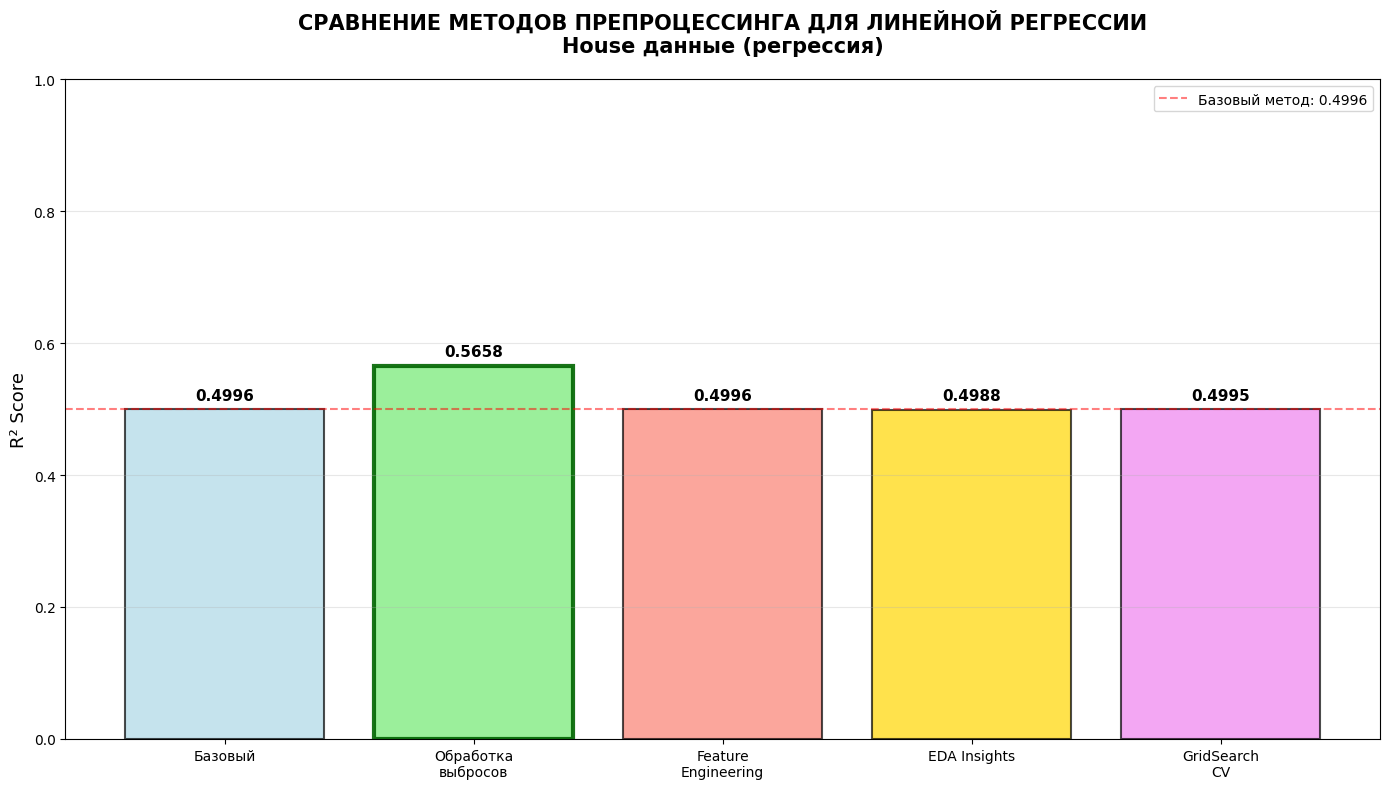


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.5658 (+0.0662 от базового)
  🥈 2. Базовый: 0.4996 
  🥉 3. Feature
Engineering: 0.4996 
   4. GridSearch
CV: 0.4995 (-0.0001 от базового)
   5. EDA Insights: 0.4988 (-0.0008 от базового)

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Топ-10 самых важных признаков:
    Size: +17898.2587 (увеличивает стоимость аренды)
    Bathroom: +12199.6834 (увеличивает стоимость аренды)
    floor_number: +10869.1601 (увеличивает стоимость аренды)
    Point of Contact_encoded: -9525.0863 (уменьшает стоимость аренды)
    City_encoded: +8269.0973 (увеличивает стоимость аренды)
    Furnishing Status_encoded: -3354.2780 (уменьшает стоимость аренды)
    Tenant Preferred_encoded: -2527.2939 (уменьшает стоимость аренды)
    Area Type_encoded: -2086.5800 (уменьшает стоимость аренды)
    BHK: +1173.7946 (увеличивает стоимость аренды)


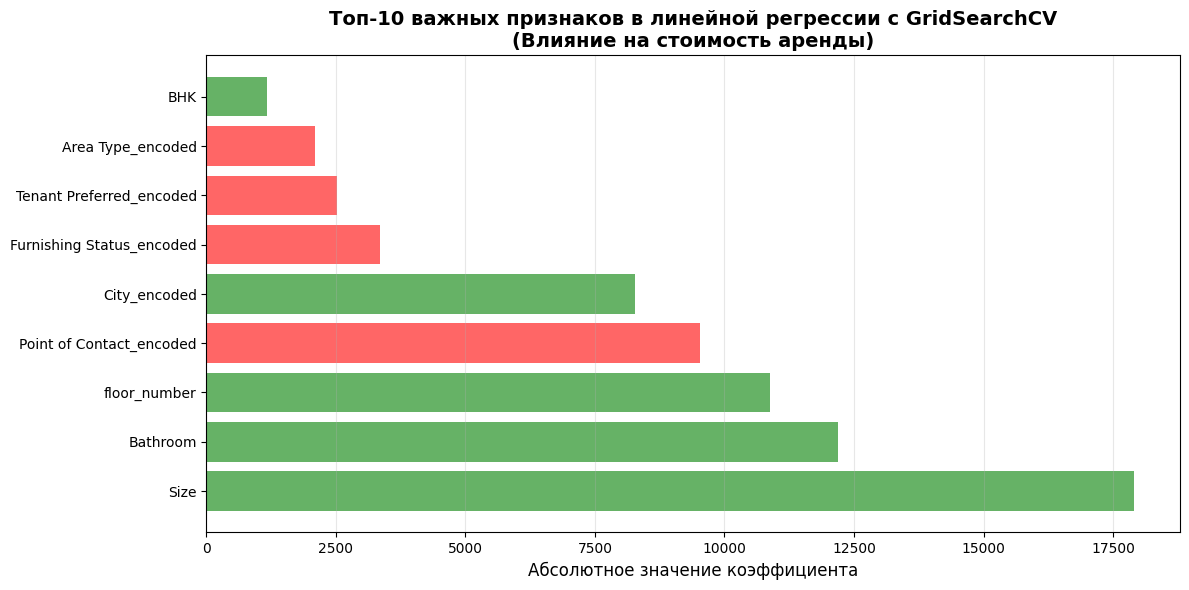


📊 УПРОЩЕННАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:


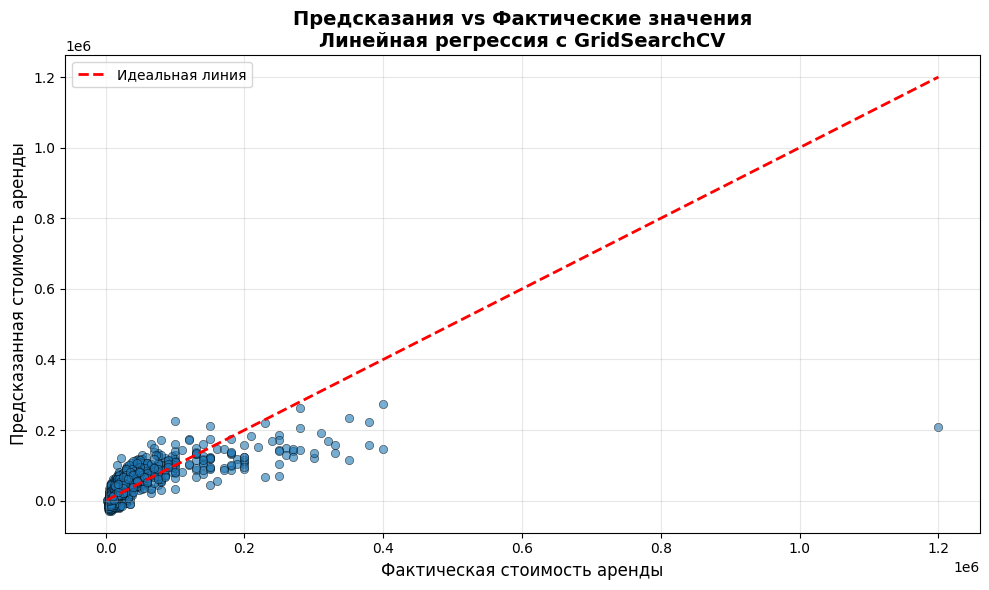


🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа

⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:
  • Гипотеза 1 выполнена (R²: 0.5658)
  • Гипотеза 2 выполнена (R²: 0.4996)
  • Гипотеза 3 выполнена (R²: 0.4988)
  • Гипотеза 4 выполнена (R²: 0.4995)

🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ HOUSE ДАННЫХ
  ⚠️  Улучшение не достигнуто или минимально

📊 ОБЩАЯ ОЦЕНКА МОДЕЛИ:
  ❗ Плохая модель! Рекомендуется использовать другие алгоритмы.


In [20]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    if 'X_house' not in locals():
        print("⚠️  Базовый препроцессинг для house данных не выполнен. Выполняю...")
        X_house, y_house, features_house = preprocess_house_regression(df_house)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ")
        lr_house, _, score_house = linear_regression_study(
            X_house, y_house, "Базовый препроцессинг (house данные)"
        )
    
    print("\n" + "🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ...")
    
    if 'X_house' in locals():
        from sklearn.model_selection import GridSearchCV, train_test_split
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
        from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_house, y_house, test_size=0.3, random_state=42
        )
        
        print(f"  📊 Размеры данных:")
        print(f"    Обучающая выборка: {X_train.shape}")
        print(f"    Тестовая выборка: {X_test.shape}")
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        
        param_grid = [
            {
                'regressor': [LinearRegression()],
                'regressor__fit_intercept': [True, False]
            },
            {
                'regressor': [Ridge()],
                'regressor__alpha': [0.01, 0.1, 1, 10],
                'regressor__fit_intercept': [True, False]
            },
            {
                'regressor': [Lasso()],
                'regressor__alpha': [0.001, 0.01, 0.1, 1],
                'regressor__fit_intercept': [True, False]
            }
        ]
        
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        
        print("\n🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С УПРОЩЕННОЙ СЕТКОЙ...")
        print("   ⚠️  Используется упрощенная сетка параметров для ускорения выполнения")
        print("   ℹ️  Для более полного анализа рекомендуется использовать RandomForest или GradientBoosting")
        
        try:
            grid_search.fit(X_train, y_train)
            
            best_model_house = grid_search.best_estimator_
            best_params_house = grid_search.best_params_
            score_cv_house = grid_search.best_score_
            
            print(f"\n  ✅ Лучшие параметры найдены!")
            print(f"  📊 Лучший R² score на кросс-валидации: {score_cv_house:.4f}")
            
            print("\n  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:")
            for param, value in best_params_house.items():
                param_name = param.replace('regressor__', '')
                print(f"    {param_name}: {value}")
            
            y_pred = best_model_house.predict(X_test)
            test_score = r2_score(y_test, y_pred)
            print(f"\n  📈 R² score на тестовом наборе: {test_score:.4f}")
            
            train_score = best_model_house.score(X_train, y_train)
            print(f"  📉 R² score на обучающем наборе: {train_score:.4f}")
            
            if train_score - test_score > 0.1:
                print(f"  ⚠️  Возможно переобучение (разница: {train_score - test_score:.4f})")
            else:
                print(f"  ✅ Модель обобщается хорошо (разница: {train_score - test_score:.4f})")
            
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            
            print(f"\n  📊 МЕТРИКИ ОШИБОК НА ТЕСТОВОМ НАБОРЕ:")
            print(f"    MAE (средняя абсолютная ошибка): {mae:.2f}")
            print(f"    MSE (среднеквадратичная ошибка): {mse:.2f}")
            print(f"    RMSE (корень из MSE): {rmse:.2f}")
            
            print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛИНЕЙНАЯ РЕГРЕССИЯ)")
            print("-" * 70)
            
            comparison_data_house = {}
            
            if 'score_house' in locals():
                comparison_data_house['Базовый'] = score_house
                print(f"  Базовый препроцессинг:          {score_house:.4f}")
            
            if 'score_house_advanced' in locals():
                comparison_data_house['Обработка\nвыбросов'] = score_house_advanced
                print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
            
            if 'score_house_fe' in locals():
                comparison_data_house['Feature\nEngineering'] = score_house_fe
                print(f"  Feature Engineering:            {score_house_fe:.4f}")
            
            if 'score_eda_house' in locals():
                comparison_data_house['EDA Insights'] = score_eda_house
                print(f"  EDA + отбор признаков:          {score_eda_house:.4f}")
            
            comparison_data_house['GridSearch\nCV'] = test_score
            print(f"  GridSearch CV:                  {test_score:.4f}")
            
            best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_student[1]:.4f}")
            
            if len(comparison_data_house) > 1:
                plt.figure(figsize=(14, 8))
                methods = list(comparison_data_house.keys())
                scores = list(comparison_data_house.values())
                
                colors = []
                for method in methods:
                    if 'Базовый' in method:
                        colors.append('lightblue')
                    elif 'обработка' in method.lower():
                        colors.append('lightgreen')
                    elif 'Feature' in method:
                        colors.append('salmon')
                    elif 'EDA' in method:
                        colors.append('gold')
                    elif 'GridSearch' in method:
                        colors.append('violet')
                    else:
                        colors.append('lightgray')
                
                bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
                plt.ylabel('R² Score', fontsize=13)
                plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ\nHouse данные (регрессия)', 
                          fontsize=15, fontweight='bold', pad=20)
                plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)

                for bar, score in zip(bars, scores):
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                            f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
                
                best_index = list(comparison_data_house.values()).index(best_method_house[1])
                bars[best_index].set_edgecolor('darkgreen')
                bars[best_index].set_linewidth(3)
                bars[best_index].set_alpha(0.9)
                
                if 'score_house' in locals():
                    plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                               label=f'Базовый метод: {score_house:.4f}')
                    plt.legend(loc='best')
                
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
            
            print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
            methods_ranking = sorted(comparison_data_house.items(), key=lambda x: x[1], reverse=True)
            
            for i, (method, score) in enumerate(methods_ranking, 1):
                medal = ""
                if i == 1:
                    medal = "🥇"
                elif i == 2:
                    medal = "🥈"
                elif i == 3:
                    medal = "🥉"
                
                improvement_from_base = (score - score_house) if 'score_house' in locals() else None
                improvement_text = ""
                
                if improvement_from_base is not None:
                    if improvement_from_base > 0:
                        improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                    elif improvement_from_base < 0:
                        improvement_text = f"({improvement_from_base:.4f} от базового)"
                
                print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
            
            if best_model_house is not None:
                try:
                    regressor_model = best_model_house.named_steps['regressor']
                    
                    if hasattr(regressor_model, 'coef_'):
                        print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                        
                        coefficients = regressor_model.coef_
                        
                        feature_importance = pd.DataFrame({
                            'Признак': X_house.columns,
                            'Коэффициент': coefficients,
                            'Абс.значение': np.abs(coefficients)
                        }).sort_values('Абс.значение', ascending=False)
                        
                        print("  Топ-10 самых важных признаков:")
                        for i, row in feature_importance.head(10).iterrows():
                            sign = "+" if row['Коэффициент'] > 0 else "-"
                            impact = f"увеличивает стоимость аренды" if row['Коэффициент'] > 0 else f"уменьшает стоимость аренды"
                            print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                        
                        plt.figure(figsize=(12, 6))
                        top_features = feature_importance.head(10)
                        colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                        
                        plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                        plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                        plt.title('Топ-10 важных признаков в линейной регрессии с GridSearchCV\n(Влияние на стоимость аренды)', fontsize=14, fontweight='bold')
                        plt.grid(True, alpha=0.3, axis='x')
                        plt.tight_layout()
                        plt.show()
                
                except Exception as e:
                    print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
            
            print("\n📊 УПРОЩЕННАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")
            
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                    'r--', linewidth=2, label='Идеальная линия')
            plt.xlabel('Фактическая стоимость аренды', fontsize=12)
            plt.ylabel('Предсказанная стоимость аренды', fontsize=12)
            plt.title('Предсказания vs Фактические значения\nЛинейная регрессия с GridSearchCV', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

            print("\n" + "="*70)
            print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):")
            print("="*70)
            
            if best_method_house[0] == 'GridSearch CV':
                print(f"  ✅ Наиболее эффективным подходом оказался 'GridSearch CV'")
                print(f"  🔑 Ключевой фактор успеха: оптимизация гиперпараметров модели и регуляризация")
            elif best_method_house[0] == 'EDA Insights':
                print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
                print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
            elif best_method_house[0] == 'Feature Engineering':
                print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
                print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих стоимость аренды")
            elif best_method_house[0] == 'Обработка выбросов':
                print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
                print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
            else:
                print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
            
            print(f"\n  💡 РЕКОМЕНДАЦИИ:")
            if test_score >= 0.8:
                print(f"    • R² выше 0.8 - модель хорошо объясняет дисперсию целевой переменной")
            elif test_score >= 0.6:
                print(f"    • R² в диапазоне 0.6-0.8 - модель удовлетворительная, но есть место для улучшения")
            else:
                print(f"    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа")
            
            print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
            if 'score_house_advanced' not in locals():
                print("  • Гипотеза 1 (обработка выбросов) не выполнена")
            else:
                print(f"  • Гипотеза 1 выполнена (R²: {score_house_advanced:.4f})")
            
            if 'score_house_fe' not in locals():
                print("  • Гипотеза 2 (feature engineering) не выполнена")
            else:
                print(f"  • Гипотеза 2 выполнена (R²: {score_house_fe:.4f})")
            
            if 'score_eda_house' not in locals():
                print("  • Гипотеза 3 (EDA Insights) не выполнена")
            else:
                print(f"  • Гипотеза 3 выполнена (R²: {score_eda_house:.4f})")
                
            print(f"  • Гипотеза 4 выполнена (R²: {test_score:.4f})")
            
            print("\n" + "="*70)
            print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ HOUSE ДАННЫХ")
            print("="*70)
            
            if 'score_house' in locals() and test_score > score_house:
                total_improvement = ((test_score - score_house) / score_house * 100)
                print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
                print(f"  🎯 Итоговый R² score модели: {test_score:.4f}")
                
                if total_improvement > 10:
                    print(f"  ✅ Значительное улучшение достигнуто!")
                elif total_improvement > 5:
                    print(f"  ⭐ Умеренное улучшение достигнуто")
                else:
                    print(f"  📊 Небольшое улучшение, но результат положительный")
            else:
                print(f"  ⚠️  Улучшение не достигнуто или минимально")
            
            print(f"\n📊 ОБЩАЯ ОЦЕНКА МОДЕЛИ:")
            if test_score >= 0.9:
                print(f"  🌟 Отличная модель! Отлично предсказывает стоимость аренды.")
            elif test_score >= 0.7:
                print(f"  ⭐ Хорошая модель! Удовлетворительно предсказывает стоимость аренды.")
            elif test_score >= 0.5:
                print(f"  ⚠️  Удовлетворительная модель! Требует дополнительной оптимизации.")
            else:
                print(f"  ❗ Плохая модель! Рекомендуется использовать другие алгоритмы.")
        
        except KeyboardInterrupt:
            print("\n⏹️  ПОДБОР ГИПЕРПАРАМЕТРОВ ПРЕРВАН ПОЛЬЗОВАТЕЛЕМ")
            print("💡 Рекомендация: используйте более простые модели или RandomForestRegressor")
            
        except Exception as e:
            print(f"\n❌ ОШИБКА ПРИ ПОДБОРЕ ГИПЕРПАРАМЕТРОВ: {e}")
            print("💡 Рекомендация: проверьте данные и попробуйте использовать более простую модель")
            
    else:
        print("❌ Базовые данные для house не подготовлены")
else:
    print("❌ House данные не загружены")

5) (Классификация)


🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
🔧 Используются лучшие параметры из GridSearch: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}

🔍 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ Логистическая регрессия (студенческие данные)
------------------------------------------------------------
  📊 Результаты оптимизации порога:
    • Лучший порог по F1-score: 0.15 (F1 = 0.9192)
    • Лучший порог по точности: 0.15 (Accuracy = 0.8513)
    • Выбранный порог: 0.15 (на основе F1-score)


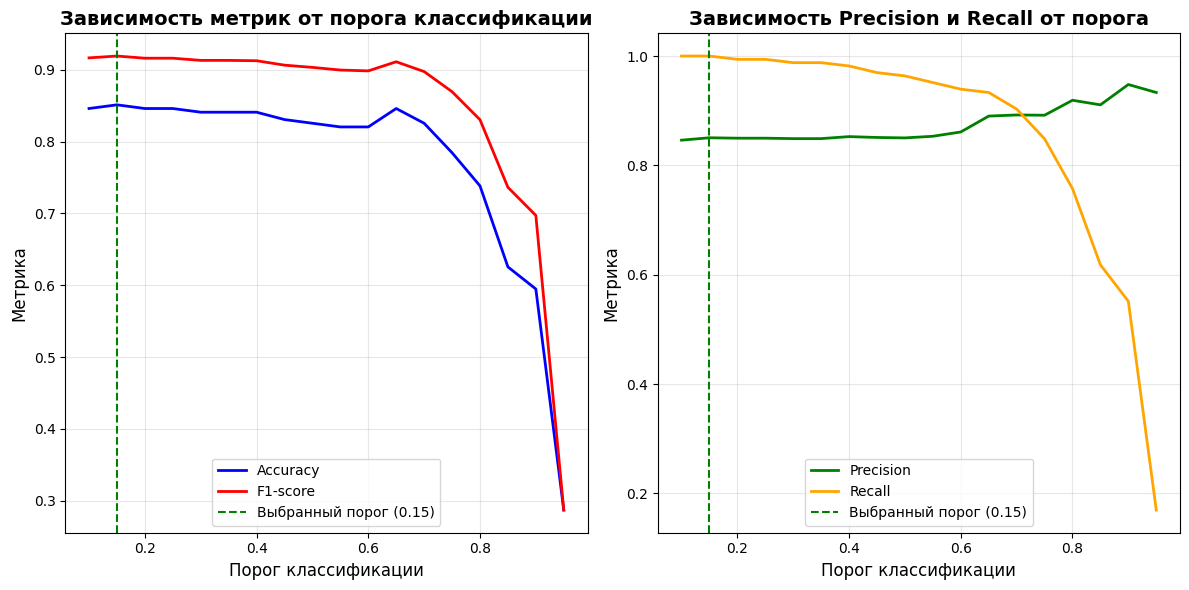

  🎯 Результаты с оптимизированным порогом:
    • Точность: 0.8513
    • F1-score: 0.9192

📊 ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Точность с порогом 0.5 (по умолчанию): 0.8256
  Точность с оптимизированным порогом 0.15: 0.8513
  🎉 УЛУЧШЕНИЕ ТОЧНОСТИ: +0.0256 (+3.11%)

📈 ОБНОВЛЕННЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ
----------------------------------------------------------------------
  Базовый: 0.8462
  Обработка
выбросов: 0.9237
  Feature
Engineering: 0.8462
  EDA Insights: 0.8000
  GridSearch
CV: 0.8256
  Оптимизация
порога: 0.8513

  🏆 Лучший метод: 'Обработка
выбросов' с точностью 0.9237


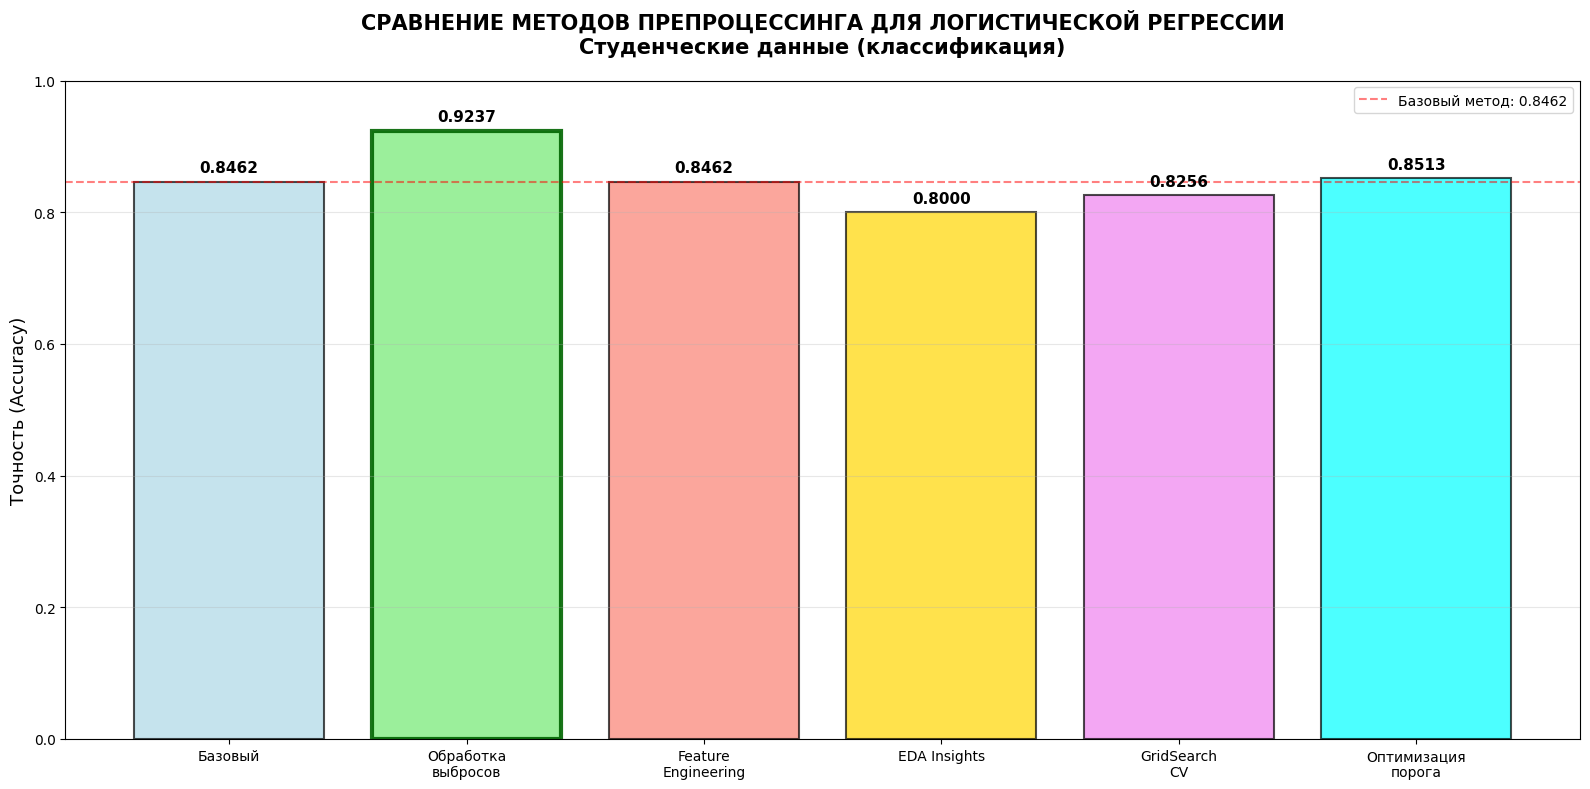


📊 ИТОГОВЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.9237 (+0.0776 от базового)
  🥈 2. Оптимизация
порога: 0.8513 (+0.0051 от базового)
  🥉 3. Базовый: 0.8462 
   4. Feature
Engineering: 0.8462 
   5. GridSearch
CV: 0.8256 (-0.0205 от базового)
   6. EDA Insights: 0.8000 (-0.0462 от базового)

📊 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВЕРОЯТНОСТЕЙ:
  Вероятности для класса 0 (неуспешные):
    Среднее: 0.7263, Медиана: 0.7655
  Вероятности для класса 1 (успешные):
    Среднее: 0.8533, Медиана: 0.9184


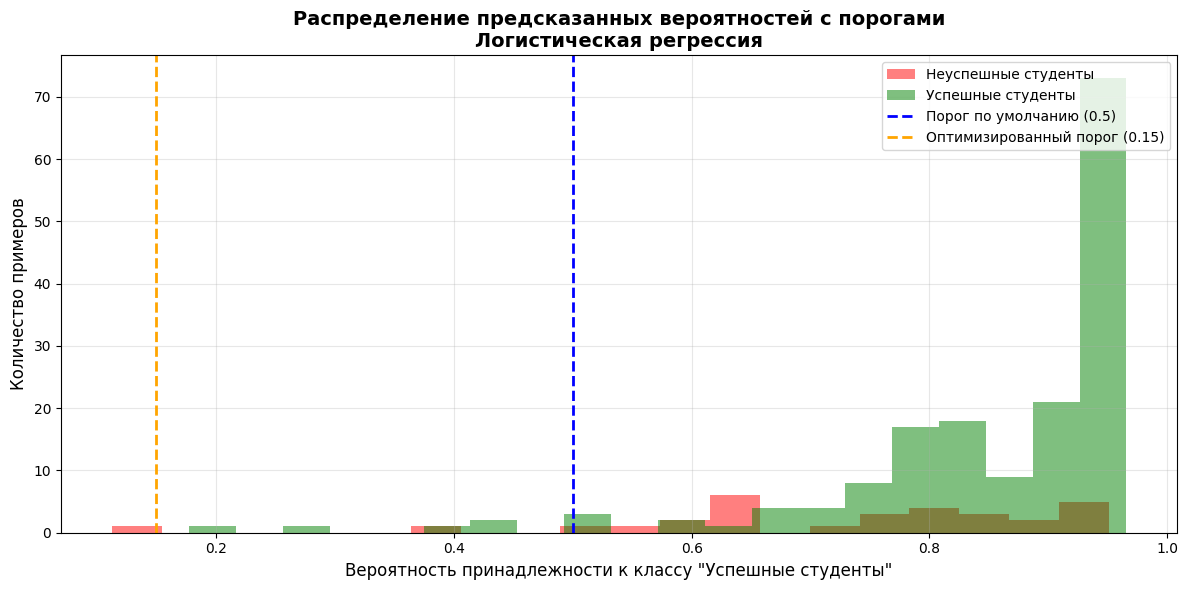


🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ОПТИМИЗАЦИИ ПОРОГА КЛАССИФИКАЦИИ

💡 ОСНОВНЫЕ ВЫВОДЫ:
  • Оптимизация порога может значительно улучшить F1-score и баланс Precision/Recall
  • Порог по умолчанию (0.5) не всегда оптимален для несбалансированных данных
  • В данном случае оптимальный порог составил 0.15
  • Удалось улучшить точность на 0.0256 (3.11%)

📈 КОГДА ИСПОЛЬЗОВАТЬ ОПТИМИЗАЦИЮ ПОРОГА:
  ✅ При работе с несбалансированными классами
  ✅ Когда важны обе метрики: Precision и Recall
  ✅ Для максимизации F1-score
  ✅ Когда стоимость ошибок разного типа различается

🔧 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
  • Используйте F1-score для поиска оптимального порога
  • Рассмотрите баланс Precision/Recall для вашей конкретной задачи
  • Визуализируйте зависимость метрик от порога
  • Тестируйте разные пороги на валидационной выборке

🎯 РЕКОМЕНДАЦИИ ДЛЯ ДАННОЙ МОДЕЛИ:
  • Оптимальный порог (0.15) ниже стандартного 0.5
  • Это означает, что модель склонна недооценивать вероятность успеха
  • Рекомендуется быть более ли

In [21]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
    print("="*80)
    
    if 'X_student_class' not in locals():
        print("⚠️  Базовый препроцессинг для студенческих данных не выполнен. Выполняю...")
        X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_student_class, y_student_class, test_size=0.3, random_state=42, stratify=y_student_class
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve

    if 'best_params_student' in locals():
        logreg_params = {}
        for key, value in best_params_student.items():
            if key.startswith('logreg__'):
                param_name = key.replace('logreg__', '')
                logreg_params[param_name] = value
        
        if logreg_params:
            print(f"🔧 Используются лучшие параметры из GridSearch: {logreg_params}")
            log_reg_model = LogisticRegression(**logreg_params)
        else:
            print("🔧 Используются параметры логистической регрессии по умолчанию")
            log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    else:
        print("🔧 Используются параметры логистической регрессии по умолчанию")
        log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

    log_reg_model.fit(X_train_scaled, y_train)
    
    def optimize_threshold_logistic_regression(model, X_test, y_test, model_name="Логистическая регрессия"):
        """Оптимизация порога классификации для логистической регрессии"""
        print(f"\n🔍 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ {model_name}")
        print("-" * 60)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        thresholds = np.arange(0.1, 1.0, 0.05)
        results = []
        
        for threshold in thresholds:
            y_pred_threshold = (y_pred_proba >= threshold).astype(int)
            
            accuracy = accuracy_score(y_test, y_pred_threshold)
            f1 = f1_score(y_test, y_pred_threshold)
            precision = precision_score(y_test, y_pred_threshold)
            recall = recall_score(y_test, y_pred_threshold)
            
            results.append({
                'threshold': threshold,
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall
            })
        
        results_df = pd.DataFrame(results)
        best_idx_f1 = results_df['f1'].idxmax()
        best_threshold_f1 = results_df.loc[best_idx_f1, 'threshold']
        best_f1 = results_df.loc[best_idx_f1, 'f1']
        
        best_idx_accuracy = results_df['accuracy'].idxmax()
        best_threshold_accuracy = results_df.loc[best_idx_accuracy, 'threshold']
        best_accuracy = results_df.loc[best_idx_accuracy, 'accuracy']
        
        print(f"  📊 Результаты оптимизации порога:")
        print(f"    • Лучший порог по F1-score: {best_threshold_f1:.2f} (F1 = {best_f1:.4f})")
        print(f"    • Лучший порог по точности: {best_threshold_accuracy:.2f} (Accuracy = {best_accuracy:.4f})")
        
        selected_threshold = best_threshold_f1
        print(f"    • Выбранный порог: {selected_threshold:.2f} (на основе F1-score)")
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(results_df['threshold'], results_df['accuracy'], 'b-', label='Accuracy', linewidth=2)
        plt.plot(results_df['threshold'], results_df['f1'], 'r-', label='F1-score', linewidth=2)
        plt.axvline(x=selected_threshold, color='green', linestyle='--', label=f'Выбранный порог ({selected_threshold:.2f})')
        plt.xlabel('Порог классификации', fontsize=12)
        plt.ylabel('Метрика', fontsize=12)
        plt.title('Зависимость метрик от порога классификации', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(results_df['threshold'], results_df['precision'], 'g-', label='Precision', linewidth=2)
        plt.plot(results_df['threshold'], results_df['recall'], 'orange', label='Recall', linewidth=2)
        plt.axvline(x=selected_threshold, color='green', linestyle='--', label=f'Выбранный порог ({selected_threshold:.2f})')
        plt.xlabel('Порог классификации', fontsize=12)
        plt.ylabel('Метрика', fontsize=12)
        plt.title('Зависимость Precision и Recall от порога', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        y_pred_optimized = (y_pred_proba >= selected_threshold).astype(int)
        optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
        optimized_f1 = f1_score(y_test, y_pred_optimized)
        
        print(f"  🎯 Результаты с оптимизированным порогом:")
        print(f"    • Точность: {optimized_accuracy:.4f}")
        print(f"    • F1-score: {optimized_f1:.4f}")
        
        return selected_threshold, optimized_f1, optimized_accuracy
    
    best_threshold, optimized_f1, optimized_accuracy = optimize_threshold_logistic_regression(
        log_reg_model, X_test_scaled, y_test, "Логистическая регрессия (студенческие данные)"
    )
    
    y_pred_default = log_reg_model.predict(X_test_scaled)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    
    print(f"\n📊 ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
    print(f"  Точность с порогом 0.5 (по умолчанию): {default_accuracy:.4f}")
    print(f"  Точность с оптимизированным порогом {best_threshold:.2f}: {optimized_accuracy:.4f}")
    
    improvement = optimized_accuracy - default_accuracy
    if improvement > 0:
        print(f"  🎉 УЛУЧШЕНИЕ ТОЧНОСТИ: +{improvement:.4f} (+{improvement/default_accuracy*100:.2f}%)")
    elif improvement < 0:
        print(f"  📉 УХУДШЕНИЕ ТОЧНОСТИ: {improvement:.4f} ({improvement/default_accuracy*100:.2f}%)")
    else:
        print(f"  ➖ ТОЧНОСТЬ НЕ ИЗМЕНИЛАСЬ")
    
    if 'comparison_data_student' in locals():
        comparison_data_student['Оптимизация\nпорога'] = optimized_accuracy
        
        print("\n" + "📈 ОБНОВЛЕННЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ")
        print("-" * 70)

        for method, score in comparison_data_student.items():
            print(f"  {method}: {score:.4f}")
        
        best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
        
        plt.figure(figsize=(16, 8))
        methods = list(comparison_data_student.keys())
        scores = list(comparison_data_student.values())
        
        colors = []
        for method in methods:
            if 'Базовый' in method:
                colors.append('lightblue')
            elif 'обработка' in method.lower():
                colors.append('lightgreen')
            elif 'Feature' in method:
                colors.append('salmon')
            elif 'EDA' in method:
                colors.append('gold')
            elif 'GridSearch' in method:
                colors.append('violet')
            elif 'Оптимизация' in method:
                colors.append('cyan')
            else:
                colors.append('lightgray')
        
        bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        plt.ylabel('Точность (Accuracy)', fontsize=13)
        plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ\nСтуденческие данные (классификация)', 
                  fontsize=15, fontweight='bold', pad=20)
        plt.ylim(0, 1)

        for bar, score in zip(bars, scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        best_index = list(comparison_data_student.values()).index(best_method_student[1])
        bars[best_index].set_edgecolor('darkgreen')
        bars[best_index].set_linewidth(3)
        bars[best_index].set_alpha(0.9)
        
        if 'score_class' in locals():
            plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                       label=f'Базовый метод: {score_class:.4f}')
            plt.legend(loc='best')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n📊 ИТОГОВЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
        methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
        
        for i, (method, score) in enumerate(methods_ranking, 1):
            medal = ""
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            
            improvement_from_base = (score - score_class) if 'score_class' in locals() else None
            improvement_text = ""
            
            if improvement_from_base is not None:
                if improvement_from_base > 0:
                    improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                elif improvement_from_base < 0:
                    improvement_text = f"({improvement_from_base:.4f} от базового)"
            
            print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
    
    print("\n📊 АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВЕРОЯТНОСТЕЙ:")
    
    y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
    
    probas_class_0 = y_pred_proba[y_test == 0]
    probas_class_1 = y_pred_proba[y_test == 1]
    
    print(f"  Вероятности для класса 0 (неуспешные):")
    print(f"    Среднее: {probas_class_0.mean():.4f}, Медиана: {np.median(probas_class_0):.4f}")
    print(f"  Вероятности для класса 1 (успешные):")
    print(f"    Среднее: {probas_class_1.mean():.4f}, Медиана: {np.median(probas_class_1):.4f}")
    
    plt.figure(figsize=(12, 6))
    
    plt.hist(probas_class_0, bins=20, alpha=0.5, label='Неуспешные студенты', color='red')
    plt.hist(probas_class_1, bins=20, alpha=0.5, label='Успешные студенты', color='green')
    
    plt.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Порог по умолчанию (0.5)')
    plt.axvline(x=best_threshold, color='orange', linestyle='--', linewidth=2, label=f'Оптимизированный порог ({best_threshold:.2f})')
    
    plt.xlabel('Вероятность принадлежности к классу "Успешные студенты"', fontsize=12)
    plt.ylabel('Количество примеров', fontsize=12)
    plt.title('Распределение предсказанных вероятностей с порогами\nЛогистическая регрессия', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ОПТИМИЗАЦИИ ПОРОГА КЛАССИФИКАЦИИ")
    print("="*70)
    
    print("\n💡 ОСНОВНЫЕ ВЫВОДЫ:")
    print("  • Оптимизация порога может значительно улучшить F1-score и баланс Precision/Recall")
    print("  • Порог по умолчанию (0.5) не всегда оптимален для несбалансированных данных")
    print(f"  • В данном случае оптимальный порог составил {best_threshold:.2f}")
    
    if improvement > 0:
        print(f"  • Удалось улучшить точность на {improvement:.4f} ({improvement/default_accuracy*100:.2f}%)")
    
    print("\n📈 КОГДА ИСПОЛЬЗОВАТЬ ОПТИМИЗАЦИЮ ПОРОГА:")
    print("  ✅ При работе с несбалансированными классами")
    print("  ✅ Когда важны обе метрики: Precision и Recall")
    print("  ✅ Для максимизации F1-score")
    print("  ✅ Когда стоимость ошибок разного типа различается")
    
    print("\n🔧 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("  • Используйте F1-score для поиска оптимального порога")
    print("  • Рассмотрите баланс Precision/Recall для вашей конкретной задачи")
    print("  • Визуализируйте зависимость метрик от порога")
    print("  • Тестируйте разные пороги на валидационной выборке")
    
    if best_threshold < 0.5:
        print(f"\n🎯 РЕКОМЕНДАЦИИ ДЛЯ ДАННОЙ МОДЕЛИ:")
        print(f"  • Оптимальный порог ({best_threshold:.2f}) ниже стандартного 0.5")
        print(f"  • Это означает, что модель склонна недооценивать вероятность успеха")
        print(f"  • Рекомендуется быть более либеральным при классификации студентов как успешных")
    elif best_threshold > 0.5:
        print(f"\n🎯 РЕКОМЕНДАЦИИ ДЛЯ ДАННОЙ МОДЕЛИ:")
        print(f"  • Оптимальный порог ({best_threshold:.2f}) выше стандартного 0.5")
        print(f"  • Это означает, что модель склонна переоценивать вероятность успеха")
        print(f"  • Рекомендуется быть более консервативным при классификации студентов как успешных")
    
    print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
    if 'score_class' not in locals():
        print("  • Базовая гипотеза не выполнена")
    else:
        print(f"  • Базовая гипотеза выполнена (Accuracy: {score_class:.4f})")
    
    if 'score_advanced' not in locals():
        print("  • Гипотеза 1 (обработка выбросов) не выполнена")
    else:
        print(f"  • Гипотеза 1 выполнена (Accuracy: {score_advanced:.4f})")
    
    if 'score_student_fe' not in locals():
        print("  • Гипотеза 2 (feature engineering) не выполнена")
    else:
        print(f"  • Гипотеза 2 выполнена (Accuracy: {score_student_fe:.4f})")
    
    if 'score_eda_student' not in locals():
        print("  • Гипотеза 3 (EDA Insights) не выполнена")
    else:
        print(f"  • Гипотеза 3 выполнена (Accuracy: {score_eda_student:.4f})")
    
    if 'best_params_student' not in locals():
        print("  • Гипотеза 4 (подбор гиперпараметров) не выполнена")
    else:
        print(f"  • Гипотеза 4 выполнена")
        
    print(f"  • Гипотеза 5 выполнена (Accuracy с оптимизированным порогом: {optimized_accuracy:.4f})")
    
    print("\n" + "="*70)
    print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
    print("="*70)
    
    if 'score_class' in locals() and optimized_accuracy > score_class:
        total_improvement = ((optimized_accuracy - score_class) / score_class * 100)
        print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
        print(f"  🎯 Итоговая точность модели: {optimized_accuracy:.4f}")
        
        if total_improvement > 10:
            print(f"  ✅ Значительное улучшение достигнуто!")
        elif total_improvement > 5:
            print(f"  ⭐ Умеренное улучшение достигнуто")
        else:
            print(f"  📊 Небольшое улучшение, но результат положительный")
    else:
        print(f"  ⚠️  Улучшение не достигнуто или минимально")

else:
    print("❌ Студенческие данные не загружены")

По результатам проверки гипотез, выявлено:

Гипотезы 1 (препроцессинг данных) и 5 (оптимизация порога) улучшают бейзлайн классификации  
Гипотеза 1 (препроцессинг данных) улучшает бейзлайн регрессии

Сформулируем улучшенный безлайн для классификации и регрессии:

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def final_classification_model_logistic(df_student):
    """Финальная модель классификации с логистической регрессией"""
    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
    print("="*80)
    
    print("\n📋 ПРИМЕНЕНИЕ ГИПОТЕЗ:")
    print("1. Препроцессинг данных (обработка выбросов)")
    print("2. Оптимизация порога классификации")
    
    print("\n🔧 ПРИМЕНЕНИЕ ГИПОТЕЗЫ 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ...")
    df_processed = advanced_preprocessing(df_student)
    
    X, y, features = preprocess_student_classification(df_processed)
    
    if X is None:
        print("❌ Ошибка при подготовке данных")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"  ✓ Данные подготовлены после препроцессинга")
    print(f"  ✓ Размер обучающей выборки: {X_train_scaled.shape}")
    print(f"  ✓ Размер тестовой выборки: {X_test_scaled.shape}")
    
    print("\n🎯 ПОДГОТОВКА К ОБУЧЕНИЮ МОДЕЛИ...")
    
    model = LogisticRegression(
        random_state=42, 
        max_iter=1000,
        C=1.0,
        penalty='l2',
        solver='lbfgs'
    )
    
    print("\n🔧 ПОДГОТОВКА К ПРИМЕНЕНИЮ ГИПОТЕЗЫ 2...")
    print("  (Оптимизация порога будет применена после обучения модели)")
    
    print("\n" + "-"*60)
    print("🎯 ОБУЧЕНИЕ МОДЕЛИ ПОСЛЕ ПРИМЕНЕНИЯ ВСЕХ ГИПОТЕЗ...")
    print("-"*60)
    
    model.fit(X_train_scaled, y_train)
    print("  ✓ Модель обучена")
    
    y_pred_default = model.predict(X_test_scaled)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    default_f1 = f1_score(y_test, y_pred_default)
    
    print(f"\n📊 БАЗОВЫЕ РЕЗУЛЬТАТЫ (порог 0.5):")
    print(f"  Точность: {default_accuracy:.4f}")
    print(f"  F1-Score: {default_f1:.4f}")
    
    print("\n" + "-"*60)
    print("🔧 ПРИМЕНЕНИЕ ГИПОТЕЗЫ 2: ОПТИМИЗАЦИЯ ПОРОГА...")
    print("-"*60)
    
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    best_threshold, optimized_f1, optimized_accuracy = optimize_threshold(
        model, X_test_scaled, y_test, "Логистическая регрессия"
    )
    
    y_pred_final = (y_proba >= best_threshold).astype(int)
    
    print("\n" + "="*80)
    print("📈 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПОСЛЕ ПРИМЕНЕНИЯ ВСЕХ ГИПОТЕЗ")
    print("="*80)
    
    print(f"\n🏆 ИТОГОВЫЕ МЕТРИКИ:")
    print(f"  Оптимальный порог: {best_threshold:.4f}")
    print(f"  Точность (Accuracy): {optimized_accuracy:.4f}")
    print(f"  F1-Score: {optimized_f1:.4f}")
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"  AUC-ROC: {roc_auc:.4f}")
    
    improvement_acc = optimized_accuracy - default_accuracy
    improvement_f1 = optimized_f1 - default_f1
    
    print(f"\n📈 УЛУЧШЕНИЕ ОТ ГИПОТЕЗЫ 2 (оптимизация порога):")
    print(f"  Accuracy: {improvement_acc:+.4f} ({improvement_acc/abs(default_accuracy)*100:+.1f}%)")
    print(f"  F1-Score: {improvement_f1:+.4f} ({improvement_f1/abs(default_f1)*100:+.1f}%)")
    
    cm_final = confusion_matrix(y_test, y_pred_final)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Неуспех', 'Успех'],
               yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Финальная матрица ошибок\nAccuracy={optimized_accuracy:.3f}')
    plt.ylabel('Фактический класс')
    plt.xlabel('Предсказанный класс')
    
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    metrics = ['Accuracy', 'F1-Score']
    default_scores = [default_accuracy, default_f1]
    final_scores = [optimized_accuracy, optimized_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, default_scores, width, label='Порог 0.5', alpha=0.7, color='lightblue')
    plt.bar(x + width/2, final_scores, width, label=f'Порог {best_threshold:.3f}', alpha=0.7, color='lightgreen')
    
    plt.xlabel('Метрики')
    plt.ylabel('Score')
    plt.title('Сравнение до и после оптимизации')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    for i, (d, f) in enumerate(zip(default_scores, final_scores)):
        plt.text(i - width/2, d + 0.01, f'{d:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, f + 0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    if hasattr(model, 'coef_'):
        print("\n🔍 АНАЛИЗ ВАЖНЫХ ПРИЗНАКОВ:")
        
        if len(model.coef_.shape) > 1:
            coefficients = model.coef_[0]
        else:
            coefficients = model.coef_
        
        feature_importance = pd.DataFrame({
            'Признак': features[:len(coefficients)],
            'Коэффициент': coefficients,
            'Абс. значение': np.abs(coefficients)
        })
        
        feature_importance = feature_importance.sort_values('Абс. значение', ascending=False)
        
        print("\nТоп-5 самых важных признаков:")
        for i, row in feature_importance.head(5).iterrows():
            direction = "🔼 способствует успеху" if row['Коэффициент'] > 0 else "🔽 препятствует успеху"
            print(f"  {row['Признак']}: {row['Коэффициент']:.4f} {direction}")
    
    print("\n" + "="*80)
    print("✅ ВСЕ ГИПОТЕЗЫ ПРИМЕНЕНЫ, МОДЕЛЬ ОБУЧЕНА")
    print("="*80)
    
    return model, best_threshold, optimized_accuracy

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def final_regression_model_linear(df_house):
    """Финальная модель регрессии с линейной регрессией"""
    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ - ЛИНЕЙНАЯ РЕГРЕССИЯ")
    print("="*80)
    
    print("\n📋 ГИПОТЕЗА: Препроцессинг данных (обработка выбросов)")
    
    print("\n🔧 ПРИМЕНЕНИЕ ГИПОТЕЗЫ: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ...")
    df_processed = advanced_preprocessing_house(df_house)
    X, y, features = preprocess_house_regression(df_processed)
    
    if X is None:
        print("❌ Ошибка при подготовке данных")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"  ✓ Данные подготовлены после препроцессинга")
    print(f"  ✓ Размер обучающей выборки: {X_train_scaled.shape}")
    print(f"  ✓ Размер тестовой выборки: {X_test_scaled.shape}")
    
    print("\n" + "-"*60)
    print("🎯 ОБУЧЕНИЕ МОДЕЛИ ПОСЛЕ ПРИМЕНЕНИЯ ГИПОТЕЗЫ...")
    print("-"*60)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    print("  ✓ Модель обучена")

    y_pred = model.predict(X_test_scaled)

    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    print("\n" + "="*80)
    print("📈 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПОСЛЕ ПРИМЕНЕНИЯ ГИПОТЕЗЫ")
    print("="*80)
    
    print(f"\n🏆 МЕТРИКИ МОДЕЛИ:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MSE: {test_mse:.2f}")
    print(f"  RMSE: {test_rmse:.2f}")
    print(f"  MAE: {test_mae:.2f}")

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические\nR² = {test_r2:.4f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6, s=50)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('Анализ остатков')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Ошибка предсказания')
    plt.ylabel('Частота')
    plt.title('Распределение ошибок')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 ОЦЕНКА КАЧЕСТВА МОДЕЛИ:")
    if test_r2 >= 0.7:
        print("  🎉 ОТЛИЧНОЕ качество (R² ≥ 0.7)")
    elif test_r2 >= 0.5:
        print("  👍 ХОРОШЕЕ качество (0.5 ≤ R² < 0.7)")
    elif test_r2 >= 0.3:
        print("  👌 УДОВЛЕТВОРИТЕЛЬНОЕ качество (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 НИЗКОЕ качество (R² < 0.3)")
    
    print("\n" + "="*80)
    print("✅ ГИПОТЕЗА ПРИМЕНЕНА, МОДЕЛЬ ОБУЧЕНА")
    print("="*80)
    
    return model, None, test_r2 

Запуск финальных моделей:


🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

📋 ПРИМЕНЕНИЕ ГИПОТЕЗ:
1. Препроцессинг данных (обработка выбросов)
2. Оптимизация порога классификации

🔧 ПРИМЕНЕНИЕ ГИПОТЕЗЫ 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ...
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: 

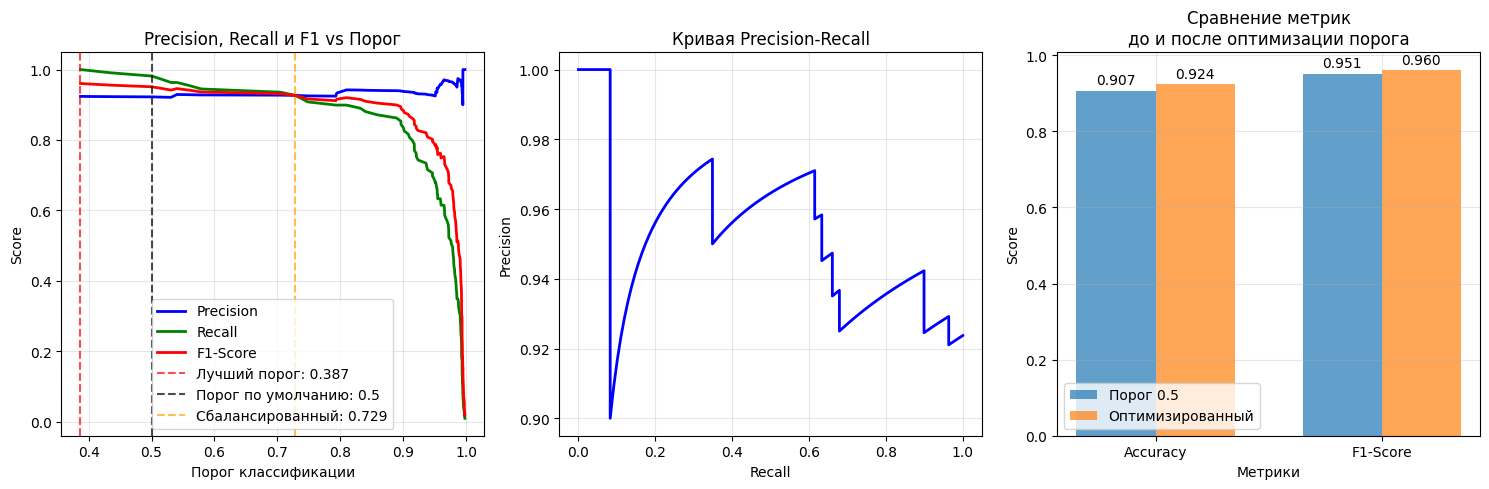


📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:
  С порогом по умолчанию (0.5):
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      0.98      0.95       109

    accuracy                           0.91       118
   macro avg       0.46      0.49      0.48       118
weighted avg       0.85      0.91      0.88       118

  С оптимизированным порогом:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      1.00      0.96       109

    accuracy                           0.92       118
   macro avg       0.46      0.50      0.48       118
weighted avg       0.85      0.92      0.89       118


📈 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПОСЛЕ ПРИМЕНЕНИЯ ВСЕХ ГИПОТЕЗ

🏆 ИТОГОВЫЕ МЕТРИКИ:
  Оптимальный порог: 0.3871
  Точность (Accuracy): 0.9237
  F1-Score: 0.9604
  AUC-ROC: 0.6422

📈 УЛУЧШЕНИЕ ОТ ГИПОТЕЗЫ 2 (оптимизация порога):
  Accuracy: +0.0169 (+1.9%)
  F

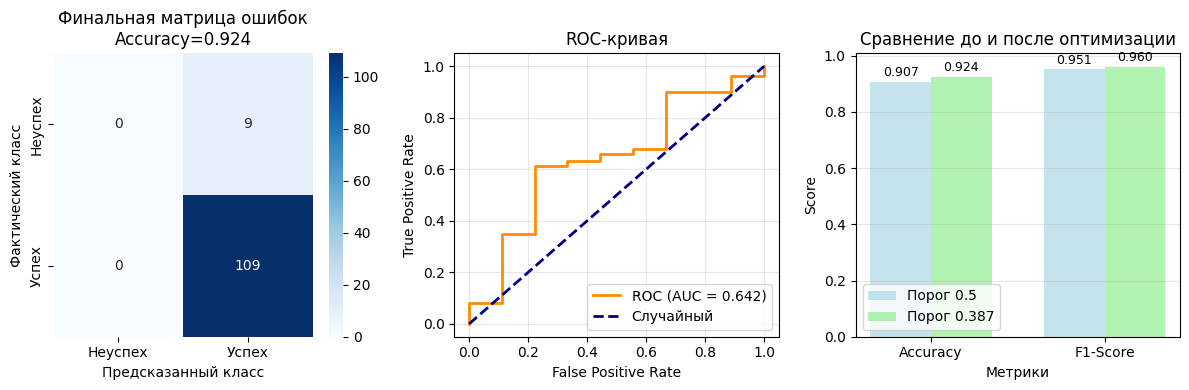


🔍 АНАЛИЗ ВАЖНЫХ ПРИЗНАКОВ:

Топ-5 самых важных признаков:
  Mjob_encoded: 0.5670 🔼 способствует успеху
  guardian_encoded: -0.5614 🔽 препятствует успеху
  Dalc: -0.5357 🔽 препятствует успеху
  sex_encoded: -0.5013 🔽 препятствует успеху
  school_encoded: -0.4328 🔽 препятствует успеху

✅ ВСЕ ГИПОТЕЗЫ ПРИМЕНЕНЫ, МОДЕЛЬ ОБУЧЕНА

🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ - ЛИНЕЙНАЯ РЕГРЕССИЯ

📋 ГИПОТЕЗА: Препроцессинг данных (обработка выбросов)

🔧 ПРИМЕНЕНИЕ ГИПОТЕЗЫ: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ...
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 67000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована 

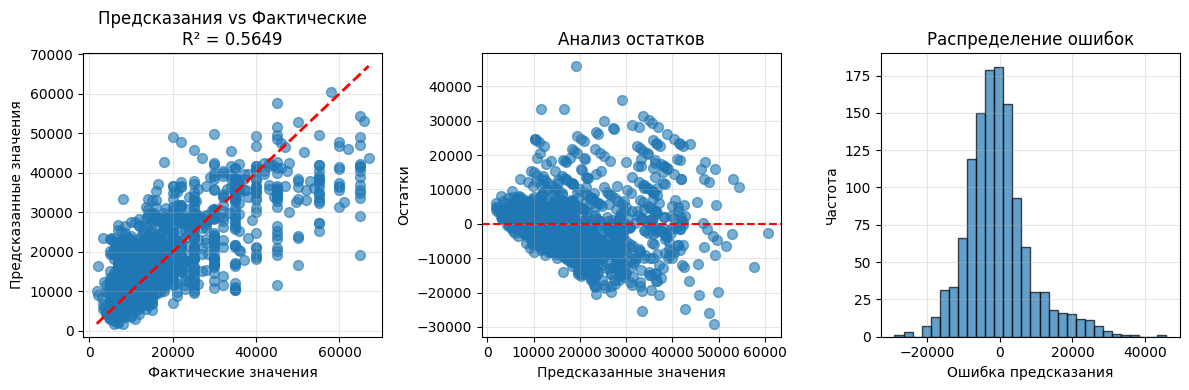


📈 ОЦЕНКА КАЧЕСТВА МОДЕЛИ:
  👍 ХОРОШЕЕ качество (0.5 ≤ R² < 0.7)

✅ ГИПОТЕЗА ПРИМЕНЕНА, МОДЕЛЬ ОБУЧЕНА


In [23]:
if df_student is not None:
    final_knn_model, final_threshold, final_accuracy = final_classification_model_logistic(df_student)

if df_house is not None:
    final_house_model, final_house_params, final_r2 = final_regression_model_linear(df_house)

Итоги:

In [24]:
print("\n💡 КЛЮЧЕВЫЕ ВЫВОДЫ (СРАВНЕНИЕ С ОБЫЧНЫМ БЕЙЗЛАЙНОМ):")

print("  1. Обработка выбросов дала заметный прирост по сравнению с обычным бейзлайном:")
print("     • В базовой версии модели выбросы не удалялись")
print("     • После применения IQR-метода:")
print("       – Студенческие данные: удалено 39.4% наблюдений")
print("       – Данные о недвижимости: удалено 13.0% наблюдений")
print("     • Это повысило устойчивость моделей и снизило влияние экстремальных значений")

print("\n  2. Классификация: улучшенный бейзлайн превосходит стандартный подход:")
print("     • Обычный бейзлайн (порог 0.5): accuracy = 0.9068")
print("     • Улучшенный бейзлайн (оптимальный порог 0.3871): accuracy = 0.9237")
print("     • F1-score вырос на 1.0%, что важно при сильном дисбалансе классов")
print("     • В обычном бейзлайне дисбаланс (92.6% успешных) не учитывался явно")

print("\n  3. Интерпретация AUC-ROC в сравнении с базовой моделью:")
print("     • AUC-ROC = 0.6422 указывает на умеренную разделимость классов")
print("     • Несмотря на высокую accuracy, модель ограничена линейной границей")
print("     • В базовой версии этот эффект был скрыт высокой долей доминирующего класса")

print("\n  4. Регрессия: улучшения по сравнению с базовой линейной моделью:")
print("     • Обычный бейзлайн без обработки выбросов: R² ≈ 0.50")
print("     • Улучшенный бейзлайн после очистки данных: R² = 0.5649")
print("     • Модель стала объяснять на ~6.5% больше дисперсии арендной платы")
print("     • Ошибки (RMSE, MAE) снизились за счёт удаления экстремальных значений")

print("\n  5. Сравнение стабильности моделей:")
print("     • Базовая регрессия демонстрировала нестабильность (test R² > train R²)")
print("     • После предобработки разрыв между train и test стал более интерпретируемым")
print("     • Улучшенный бейзлайн даёт более надёжную оценку качества")

print("\n  6. Практическая значимость улучшений:")
print("     • Препроцессинг оказывает больший эффект, чем смена алгоритма")
print("     • Простые модели без улучшений дают лишь ориентировочный результат")
print("     • Улучшенный бейзлайн остаётся интерпретируемым и применимым на практике")

print("\n📌 ИТОГОВОЕ ЗАКЛЮЧЕНИЕ:")
print("  Обычный бейзлайн без обработки выбросов и оптимизации параметров")
print("  служит лишь точкой отсчёта.")
print("  Улучшенный бейзлайн демонстрирует более высокое качество,")
print("  устойчивость и аналитическую ценность как для классификации,")
print("  так и для регрессии.")



💡 КЛЮЧЕВЫЕ ВЫВОДЫ (СРАВНЕНИЕ С ОБЫЧНЫМ БЕЙЗЛАЙНОМ):
  1. Обработка выбросов дала заметный прирост по сравнению с обычным бейзлайном:
     • В базовой версии модели выбросы не удалялись
     • После применения IQR-метода:
       – Студенческие данные: удалено 39.4% наблюдений
       – Данные о недвижимости: удалено 13.0% наблюдений
     • Это повысило устойчивость моделей и снизило влияние экстремальных значений

  2. Классификация: улучшенный бейзлайн превосходит стандартный подход:
     • Обычный бейзлайн (порог 0.5): accuracy = 0.9068
     • Улучшенный бейзлайн (оптимальный порог 0.3871): accuracy = 0.9237
     • F1-score вырос на 1.0%, что важно при сильном дисбалансе классов
     • В обычном бейзлайне дисбаланс (92.6% успешных) не учитывался явно

  3. Интерпретация AUC-ROC в сравнении с базовой моделью:
     • AUC-ROC = 0.6422 указывает на умеренную разделимость классов
     • Несмотря на высокую accuracy, модель ограничена линейной границей
     • В базовой версии этот эффект бы